# Defesa - Análise de Resultados DLAFE - VGG16 ImageNet vs. NILMNETA30d
---
Avaliação sistemática dos resultados obtidos considerando os resultados obtidos pelo método de extração baseado em arquitetura VGG16 pré-treinada no dataset Imagenet contra a mesma arquitetura feita um ajuste-fino com os dados das bases UKDALE e REDD (modelos por carga para 30 dias de dados - NILMNETA30d).

# Configurações e Dados

In [1]:
import os
import sys
import gc
from pprint import pprint
from collections import Counter
import copy
import warnings
warnings.filterwarnings(action="ignore")

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
# matplotlib.style.use('ggplot')
from matplotlib import pyplot as plt
from IPython.display import display

from tqdm import *
from glob import glob

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK) e outros insumos fundamentais
caminho_dados = "D:/Projetos/phd-thesis/datasets/"

# Definir diretorios onde iremos salvar os insumos gerados do notebook (dados, imagens, etc.)
caminho_dados_notebook = os.path.join(caminho_dados, "29") # Num. notebook
if not os.path.isdir(caminho_dados_notebook):
    os.makedirs(caminho_dados_notebook)
    
caminho_imagens_notebook = os.path.join(caminho_dados_notebook, "imagens") # Num. notebook
if not os.path.isdir(caminho_imagens_notebook):
    os.makedirs(caminho_imagens_notebook)

In [2]:
pd.options.display.float_format = "{:,.3f}".format

In [32]:
df_melhores_taxas_janelas = pd.read_csv(
    os.path.join(caminho_dados, "27", "melhores_taxa_janela_aparelhos_ieee2021.csv"), 
    index_col=0).rename(columns={'carga':'appliance', 'janela': 'window_length'})[
        ['appliance', 'window_length']]
df_melhores_taxas_janelas

,appliance,window_length
0,dish_washer - 9,2040
1,fridge - 7,720
2,microwave - 16,900
3,washer_dryer - 13,90
4,washer_dryer - 14,2040


In [3]:
# datasets = []

# # Resultados abordagem 1 (RQA + Machine Learning)
# for arquivo in glob(os.path.join(caminho_dados, "22/df_resultados_*.xlsx")):
#     df_ = pd.read_excel(arquivo, index_col=0, engine="openpyxl")
#     df_["method"] = "RQA+"+arquivo.split("\\")[-1].split('.xlsx')[0].split('_')[-1].upper()
#     datasets.append(df_)

# # Resultados abordagem 2 (RP DeepLearning Automatic Feature Extraction + Machine Learning)
# for arquivo in glob(os.path.join(caminho_dados, "23/df_resultados_*.xlsx")):
#     df_ = pd.read_excel(arquivo, index_col=0, engine="openpyxl")
#     df_["method"] = "DTLFE+"+arquivo.split("\\")[-1].split('.xlsx')[0].split('_')[-1].upper()
#     datasets.append(df_)

# # TODO: Incluir CNN
# # Resultados abordagem 3 (end-to-end CNN)
# df_ = pd.read_excel(
#     os.path.join(caminho_dados, "20/residencia_3/resultados_baseline.xlsx"),
#     engine="openpyxl"
# ).rename(columns={
#     'aparelho': 'appliance',
#     'teste': 'test',
#     'acuracia': 'acc',
#     'iteracao': 'iteration',
#     'metodologia': 'method'
# })
# df_ = df_.query("test==1 or base=='teste'") # Selecionando apenas 1 rodada de teste
# del df_["test"]
# df_["method"] = "RP+CNN"
# datasets.append(df_)

# # Dataframe com todos resultados
# df = pd.concat(datasets)

In [52]:
# COnjunto de dados de resultados utilizando DTLFE-imagenet (quali)
datasets = []
modelos_avaliados = ['MLP','SVM','XGBOOST']

# # Resultados abordagem 1 (RQA + Machine Learning)
# for modelo in modelos_avaliados:
#     pasta = os.path.join(caminho_dados, '25', 'RQA', modelo)
#     df_ = pd.read_excel(os.path.join(pasta, "df_resultados_janelas.xlsx"), index_col=0, engine='openpyxl')
#     df_["method"] = f'RQA+{modelo}'
#     datasets.append(df_)

# Resultados abordagem 2 (RP DeepLearning Automatic Feature Extraction + Machine Learning)
for modelo in modelos_avaliados:
    pasta = os.path.join(caminho_dados, '25', modelo)
    df_ = pd.read_excel(os.path.join(pasta, "df_resultados_janelas.xlsx"), index_col=0, engine='openpyxl')
    df_["model"] = modelo
    datasets.append(df_)


# # # TODO: Incluir CNN
# # Resultados abordagem 3 (end-to-end CNN)
# df_ = pd.read_excel(os.path.join(caminho_dados, '25', 'RP_CNN', "df_resultados_janelas.xlsx"), index_col=0, engine='openpyxl')
# df_["method"] = 'RP+CNN'
# datasets.append(df_)
# # df_ = pd.read_excel(
# #     os.path.join(caminho_dados, "20/residencia_3/resultados_baseline.xlsx"),
# #     engine="openpyxl"
# # ).rename(columns={
# #     'aparelho': 'appliance',
# #     'teste': 'test',
# #     'acuracia': 'acc',
# #     'iteracao': 'iteration',
# #     'metodologia': 'method'
# # })
# # df_ = df_.query("test==1 or base=='teste'") # Selecionando apenas 1 rodada de teste
# # del df_["test"]
# # df_["method"] = "RP+CNN"
# # datasets.append(df_)

# Dataframe com todos resultados
df_imagenet = pd.concat(datasets)[['appliance', 'window_length', 'fold', 'acc', 'f1', 'auc', 'base', 'model']]
df_imagenet['transfer_learning_method'] = 'imagenet'

# selecionando apenas registros com base nas melhores janelas por aparelho (IEEE2021)
df_imagenet = df_imagenet.query(' | '.join([
    f"(appliance=='{r['appliance']}' & window_length=={r['window_length']})" \
        for _, r in df_melhores_taxas_janelas.iterrows()])).reset_index(drop=True)
df_imagenet

,appliance,window_length,fold,acc,f1,auc,base,model,transfer_learning_method
0,dish_washer - 9,2040,1,0.957,0.489,0.500,treino,MLP,imagenet
1,dish_washer - 9,2040,2,0.957,0.489,0.500,treino,MLP,imagenet
2,dish_washer - 9,2040,3,0.957,0.489,0.500,treino,MLP,imagenet
3,dish_washer - 9,2040,4,0.913,0.477,0.477,treino,MLP,imagenet
4,dish_washer - 9,2040,5,0.957,0.489,0.500,treino,MLP,imagenet
...,...,...,...,...,...,...,...,...,...
160,washer_dryer - 14,2040,7,0.957,0.822,0.750,treino,XGBOOST,imagenet
161,washer_dryer - 14,2040,8,0.957,0.822,0.750,treino,XGBOOST,imagenet
162,washer_dryer - 14,2040,9,1.000,1.000,1.000,treino,XGBOOST,imagenet
163,washer_dryer - 14,2040,10,1.000,1.000,1.000,treino,XGBOOST,imagenet


In [55]:
df_nilmnetA30d = pd.read_excel(
    os.path.join(caminho_dados, '28', 'df_analise.xlsx'), 
    index_col=0, engine='openpyxl')[[
        'appliance', 'fold', 'acc', 'f1', 'auc', 
        'base', 'model', 'transfer_learning_method']]
df_nilmnetA30d

,appliance,fold,acc,f1,auc,base,model,transfer_learning_method
0,dish_washer - 9,1,0.957,0.489,0.500,treino,SVM,nilmnetA30d
1,dish_washer - 9,2,0.957,0.489,0.500,treino,SVM,nilmnetA30d
2,dish_washer - 9,3,0.957,0.489,0.500,treino,SVM,nilmnetA30d
3,dish_washer - 9,4,0.957,0.489,0.500,treino,SVM,nilmnetA30d
4,dish_washer - 9,5,0.957,0.489,0.500,treino,SVM,nilmnetA30d
...,...,...,...,...,...,...,...,...
50,washer_dryer - 14,7,1.000,1.000,1.000,treino,MLP,nilmnetA30d
51,washer_dryer - 14,8,0.783,0.579,0.655,treino,MLP,nilmnetA30d
52,washer_dryer - 14,9,0.870,0.747,0.929,treino,MLP,nilmnetA30d
53,washer_dryer - 14,10,0.818,0.450,0.429,treino,MLP,nilmnetA30d


In [56]:
# COmbinando resultados para analise
df_geral = pd.concat([
    df_imagenet, df_nilmnetA30d
])
df_geral

,acc,appliance,auc,base,f1,fold,model,transfer_learning_method,window_length
0,0.957,dish_washer - 9,0.500,treino,0.489,1,MLP,imagenet,"2,040.000"
1,0.957,dish_washer - 9,0.500,treino,0.489,2,MLP,imagenet,"2,040.000"
2,0.957,dish_washer - 9,0.500,treino,0.489,3,MLP,imagenet,"2,040.000"
3,0.913,dish_washer - 9,0.477,treino,0.477,4,MLP,imagenet,"2,040.000"
4,0.957,dish_washer - 9,0.500,treino,0.489,5,MLP,imagenet,"2,040.000"
...,...,...,...,...,...,...,...,...,...
50,1.000,washer_dryer - 14,1.000,treino,1.000,7,MLP,nilmnetA30d,nan
51,0.783,washer_dryer - 14,0.655,treino,0.579,8,MLP,nilmnetA30d,nan
52,0.870,washer_dryer - 14,0.929,treino,0.747,9,MLP,nilmnetA30d,nan
53,0.818,washer_dryer - 14,0.429,treino,0.450,10,MLP,nilmnetA30d,nan


# Análises

In [9]:
colors = ['#00BA38', '#598BDF', '#F8766D']

## Estatísticas gerais

In [57]:
# manter copia (janela fixa)
df = df_geral.query('base=="teste"').copy()

In [11]:
# df['feature'] = df['method'].apply(lambda m: m.split('+')[0])

In [12]:
# print("* Análise por extracao de atributos/janelas:")
# df_analise_feature_window = df[df["base"]=="teste"].groupby(["window_length"]).agg({
#     "acc": ["mean","std"],
#     "f1": ["mean","std"],
#     "auc": ["mean","std"]
# }).reset_index().sort_values(('f1','mean'), ascending=False).set_index("window_length")
# display(df_analise_feature_window)

## Comparativo

In [63]:
# melhor_janela_global = 2040

# df = df[df["window_length"]==melhor_janela_global]

print("* Análise por método de extracao de atributos:")
df_transfer_learning = df.groupby(["transfer_learning_method"]).agg({
    "acc": ["mean","std"],
    "f1": ["mean","std"],
    "auc": ["mean","std"]
}).reset_index().sort_values(('f1','mean'), ascending=False).set_index("transfer_learning_method")
display(df_transfer_learning)
df_transfer_learning.to_excel(os.path.join(caminho_dados_notebook, "df_transfer_learning.xlsx"))
print()


print()
print("* Análise por método de extracao de atributos/Classificador:")
df_feature_classificador = df.groupby([ "model", "transfer_learning_method",]).agg({
    "acc": ["mean","std"],
    "f1": ["mean","std"],
    "auc": ["mean","std"]
}).sort_values(["model",('f1','mean')],ascending=[True,False])
display(df_feature_classificador)
df_feature_classificador.to_excel(os.path.join(caminho_dados_notebook, "df_feature_classificador.xlsx"))
# print("* Análise por metodologia:")
# df_metodo = df[df["base"]=="teste"].groupby(["method","base"]).agg({
#     "acc": ["mean","std"],
#     "f1": ["mean","std"],
#     "auc": ["mean","std"]
# }).reset_index().sort_values(('f1','mean'), ascending=False).set_index("method")
# display(df_metodo)
# df_metodo.to_excel(os.path.join(caminho_dados_notebook, "df_metodo.xlsx"))

# print()
# print("* Análise por aparelho/método de extracao de atributos:")
# df_aparelho = df.groupby(["appliance","transfer_learning_method"]).agg({
#     "acc": ["mean","std"],
#     "f1": ["mean","std"],
#     "auc": ["mean","std"]
# }).sort_values(["appliance",('f1','mean')],ascending=[True,False])
# display(df_aparelho)
# df_aparelho.to_excel(os.path.join(caminho_dados_notebook, "df_aparelho.xlsx"))

print()
print("* Análise por método de extracao de atributos/Classificador/aparelho:")
df_classificador = df.groupby(["appliance", "model","transfer_learning_method"]).agg({
    "acc": ["mean","std"],
    "f1": ["mean","std"],
    "auc": ["mean","std"]
}).sort_values(["appliance",('f1','mean')],ascending=[True,False])
display(df_classificador)
df_classificador.to_excel(os.path.join(caminho_dados_notebook, "df_aparelho_classificador.xlsx"))

* Análise por método de extracao de atributos:


acc          f1         auc      
                          mean   std  mean   std  mean   std
transfer_learning_method                                    
imagenet                 0.967 0.023 0.788 0.187 0.767 0.180
nilmnetA30d              0.954 0.031 0.714 0.196 0.702 0.185



* Análise por método de extracao de atributos/Classificador:


acc          f1         auc      
                                  mean   std  mean   std  mean   std
model   transfer_learning_method                                    
MLP     imagenet                 0.967 0.023 0.832 0.127 0.811 0.140
        nilmnetA30d              0.940 0.039 0.682 0.161 0.668 0.156
SVM     imagenet                 0.966 0.026 0.720 0.243 0.707 0.233
        nilmnetA30d              0.961 0.027 0.682 0.250 0.679 0.237
XGBOOST imagenet                 0.968 0.027 0.812 0.197 0.783 0.180
        nilmnetA30d              0.962 0.027 0.776 0.195 0.758 0.182


* Análise por método de extracao de atributos/Classificador/aparelho:


acc        f1       auc  \
                                                    mean std  mean std  mean   
appliance         model   transfer_learning_method                             
dish_washer - 9   MLP     imagenet                 0.932 nan 0.625 nan 0.593   
                  SVM     nilmnetA30d              0.932 nan 0.483 nan 0.500   
                  XGBOOST nilmnetA30d              0.932 nan 0.483 nan 0.500   
                  SVM     imagenet                 0.932 nan 0.482 nan 0.500   
                  XGBOOST imagenet                 0.932 nan 0.482 nan 0.500   
                  MLP     nilmnetA30d              0.926 nan 0.481 nan 0.496   
fridge - 7        XGBOOST imagenet                 0.990 nan 0.931 nan 0.882   
                  MLP     imagenet                 0.980 nan 0.870 nan 0.849   
                  XGBOOST nilmnetA30d              0.976 nan 0.837 nan 0.802   
                  MLP     nilmnetA30d              0.973 nan 0.803 nan 0.747   
                  SVM     imagenet                 0.958 nan 0.489 nan 0.500   
                          nilmnetA30d              0.956 nan 0.489 nan 0.500   
microwave - 16    MLP     imagenet                 0.963 nan 0.814 nan 0.770   
                  XGBOOST imagenet                 0.960 nan 0.804 nan 0.768   
                          nilmnetA30d              0.939 nan 0.690 nan 0.664   
                  SVM     imagenet                 0.954 nan 0.688 nan 0.625   
                  MLP     nilmnetA30d              0.936 nan 0.644 nan 0.615   
                  SVM     nilmnetA30d              0.939 nan 0.530 nan 0.523   
washer_dryer - 13 XGBOOST imagenet                 0.998 nan 0.988 nan 0.981   
                  SVM     imagenet                 0.998 nan 0.984 nan 0.981   
                  XGBOOST nilmnetA30d              0.997 nan 0.980 nan 0.973   
                  SVM     nilmnetA30d              0.996 nan 0.976 nan 0.980   
                  MLP     imagenet                 0.993 nan 0.955 nan 0.960   
                          nilmnetA30d              0.981 nan 0.883 nan 0.896   
washer_dryer - 14 SVM     imagenet                 0.986 nan 0.958 nan 0.929   
                          nilmnetA30d              0.980 nan 0.934 nan 0.893   
                  MLP     imagenet                 0.966 nan 0.898 nan 0.885   
                  XGBOOST nilmnetA30d              0.966 nan 0.891 nan 0.853   
                          imagenet                 0.959 nan 0.853 nan 0.786   
                  MLP     nilmnetA30d              0.885 nan 0.599 nan 0.585   

                                                        
                                                   std  
appliance         model   transfer_learning_method      
dish_washer - 9   MLP     imagenet                 nan  
                  SVM     nilmnetA30d              nan  
                  XGBOOST nilmnetA30d              nan  
                  SVM     imagenet                 nan  
                  XGBOOST imagenet                 nan  
                  MLP     nilmnetA30d              nan  
fridge - 7        XGBOOST imagenet                 nan  
                  MLP     imagenet                 nan  
                  XGBOOST nilmnetA30d              nan  
                  MLP     nilmnetA30d              nan  
                  SVM     imagenet                 nan  
                          nilmnetA30d              nan  
microwave - 16    MLP     imagenet                 nan  
                  XGBOOST imagenet                 nan  
                          nilmnetA30d              nan  
                  SVM     imagenet                 nan  
                  MLP     nilmnetA30d              nan  
                  SVM     nilmnetA30d              nan  
washer_dryer - 13 XGBOOST imagenet                 nan  
                  SVM     imagenet                 nan  
                  XGBOOST nilmnetA30d              nan  
                  SVM     nilmnetA30d       

In [62]:
# df_analise[ (df_analise["base"]=="teste") & (df_analise["method"]=="RP+CNN") ].groupby('appliance').agg({'f1':['max']})


# Fim!

## Comparativo entre metodologias - RQA vs. DTLFE

In [71]:
# libraries
import seaborn as sns

matplotlib.style.use('default')
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = 'gray'
matplotlib.rcParams['grid.linestyle'] = '-'
matplotlib.rcParams['grid.linewidth'] = 0.25
matplotlib.rcParams['grid.alpha'] = .5
sns.set(font_scale=1.8, style=None, palette=None)

def order_values_plot(df, column, values):
    key = df[column].map({v: i for i, v in enumerate(values)}) # df_avg['feature'].unique().tolist()
    return df.iloc[key.argsort()]


In [72]:
# matplotlib.rcParams.keys()

### Desempenho Médio Geral

Metodologias - Desempenho Médio Geral (base = teste)


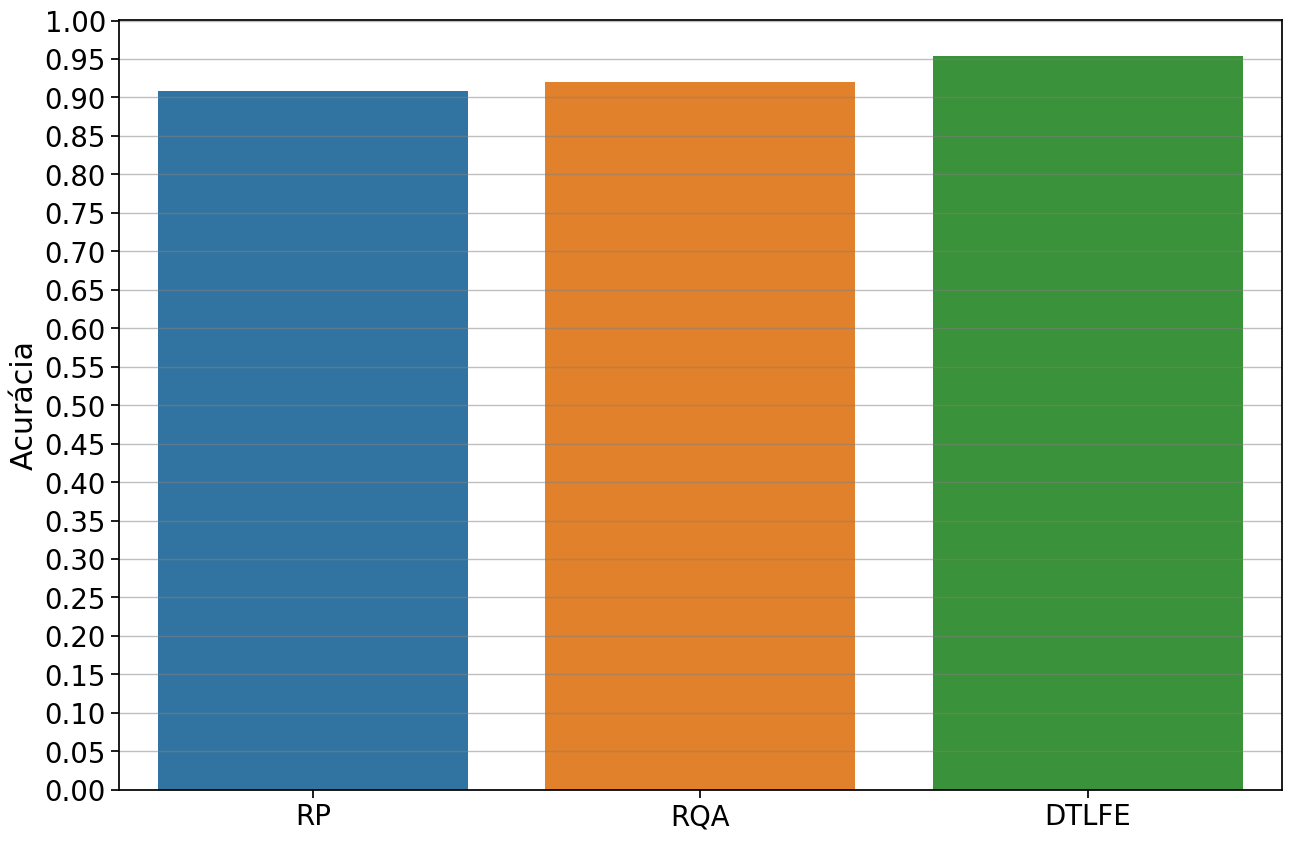

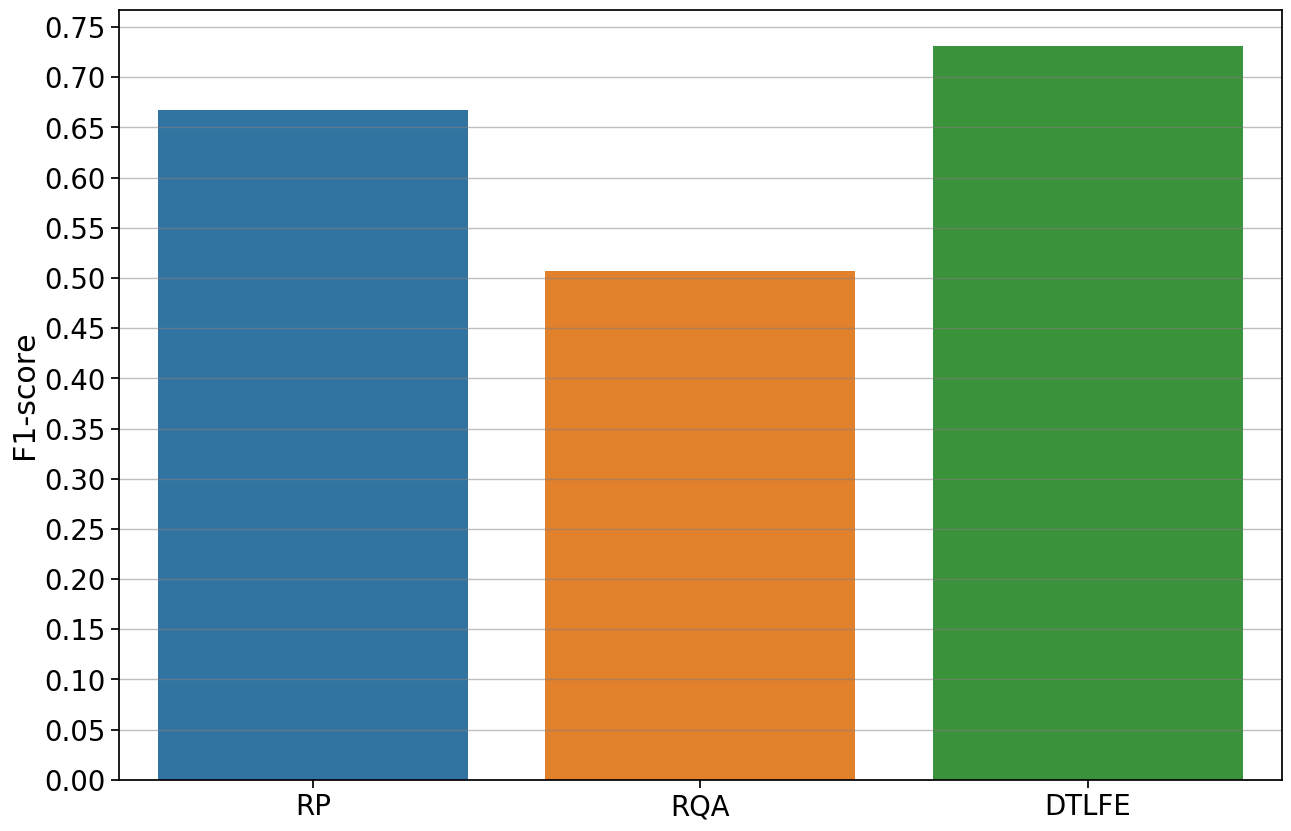

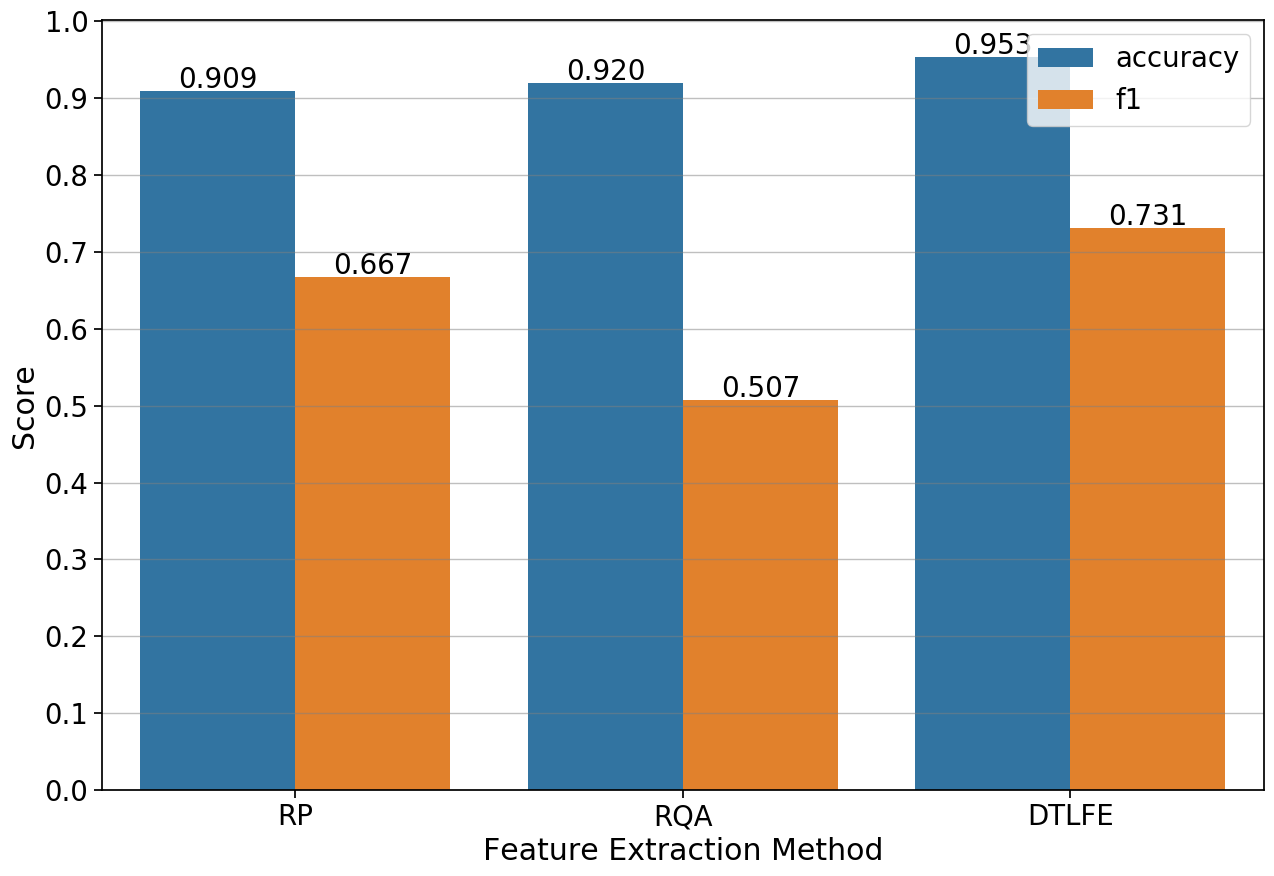

In [73]:
for b in ['teste']:
    df_ = df.query(f"base == '{b}'").reset_index()
    
    df_['feature'] = df_['method'].apply(lambda m: m.split('+')[0])
    df_['classifier'] = df_['method'].apply(lambda m: m.split('+')[1]) 
    
    # Ordenar grafico por atributo
    df_ = order_values_plot(df_, column='feature', values=['RP','RQA','DTLFE'])
    
    # fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,6))
    print(f'Metodologias - Desempenho Médio Geral (base = {b})')
    if b == 'treino':
        fig, ax = plt.subplots(figsize=(15,10))
        g=sns.histplot(
            df_, x="acc", hue="feature", 
            stat="probability", # kde=True,
            ax=ax, 
            alpha=.75,
            # palette=colors
        )
        g.legend_.set_title(None)
        ax.set_xlabel('Acurácia')
        ax.set_ylabel('Probabilidade')
        plt.show()
        fig.savefig(
            os.path.join(
                caminho_imagens_notebook,
                '1_geral_treino_acuracia.png', 
            ),
            format='png', 
            dpi=300,
            bbox_inches='tight', 
            pad_inches=0
        )
        
        
        fig, ax = plt.subplots(figsize=(15,10))
        g=sns.histplot(
            df_, x="f1", hue="feature", 
            stat="probability", # kde=True,
            ax=ax, 
            alpha=.75,
            # palette=colors
        )
        g.legend_.set_title(None)
        ax.set_xlabel('F1-score')
        ax.set_ylabel('Probabilidade')
        plt.show()
        fig.savefig(
            os.path.join(
                caminho_imagens_notebook,
                '1_geral_treino_f1.png', 
            ),
            format='png', 
            dpi=300,
            bbox_inches='tight', 
            pad_inches=0
        )
        
        # Data
        df_avg = df_.groupby('feature').agg({'f1':{'mean'}, 'acc': {'mean'}}).reset_index(drop=False)
        df_avg.columns = df_avg.columns.get_level_values(0)
        # Order
        df_avg = order_values_plot(df_avg, column='feature', values=['RP','RQA','DTLFE'])
        rows = []
        for _, r in df_avg.iterrows():
            rows.append({
                'feature': r['feature'],
                'metric': 'accuracy',
                'value': r['acc']
            })
            rows.append({
                'feature': r['feature'],
                'metric': 'f1',
                'value': r['f1']
            })
        df_avg = pd.DataFrame(rows)

        fig, ax = plt.subplots(figsize=(15,10))
        g=sns.barplot(x="feature", y="value", hue="metric", data=df_avg)
        g.legend_.set_title(None)
        ax.set(
            title='', 
            ylabel='Score', xlabel='Método de Extração de Atributos',            
            #xticklabels=df_avg['feature'],
            yticks=np.arange(0, np.max(df_avg['value'])+.05, .05)  
        );
        plt.show()
        fig.savefig(
            os.path.join(
                caminho_imagens_notebook,
                '1_geral_treino.png', 
            ),
            format='png', 
            dpi=300,
            bbox_inches='tight', 
            pad_inches=0
        )
        
    else:
        
        # Buscar o valor MODA
        
        df_avg = df_.groupby('feature').agg({'acc':{'mean'}}).reset_index(drop=False)
        df_avg.columns = df_avg.columns.get_level_values(0)
        # Order
        df_avg = order_values_plot(df_avg, column='feature', values=['RP','RQA','DTLFE'])
        # Plot
        fig, ax = plt.subplots(figsize=(15,10))
        sns.barplot(x="feature", y="acc", data=df_avg, ax=ax)
        ax.set(
            title='', 
            xlabel='', ylabel='Acurácia',            
            xticklabels=df_avg['feature'],
            yticks=np.arange(0, np.max(df_avg['acc'])+.05, .05)  
        );
        plt.show()
        fig.savefig(
            os.path.join(
                caminho_imagens_notebook,
                '1_geral_teste_acuracia.png',
            ),
            format='png', 
            dpi=300,
            bbox_inches='tight', 
            pad_inches=0
        )

        df_avg = df_.groupby('feature').agg({'f1':{'mean'}}).reset_index(drop=False)
        df_avg.columns = df_avg.columns.get_level_values(0)
        # Order
        df_avg = order_values_plot(df_avg, column='feature', values=['RP','RQA','DTLFE'])
        # Plot
        fig, ax = plt.subplots(figsize=(15,10))
        sns.barplot(x="feature", y="f1", data=df_avg, ax=ax)
        ax.set(
            title='', 
            xlabel='', ylabel='F1-score',            
            xticklabels=df_avg['feature'],
            yticks=np.arange(0, np.max(df_avg['f1'])+.05, .05)  
        );
        plt.show()
        fig.savefig(
            os.path.join(
                caminho_imagens_notebook,
                '1_geral_teste_f1.png', 
            ),
            format='png', 
            dpi=300,
            bbox_inches='tight', 
            pad_inches=0
        )

        # Data
        df_avg = df_.groupby('feature').agg({'f1':{'mean'}, 'acc': {'mean'}}).reset_index(drop=False)
        df_avg.columns = df_avg.columns.get_level_values(0)
        # Order
        df_avg = order_values_plot(df_avg, column='feature', values=['RP','RQA','DTLFE'])
        rows = []
        for _, r in df_avg.iterrows():
            rows.append({
                'feature': r['feature'],
                'metric': 'accuracy',
                'value': r['acc']
            })
            rows.append({
                'feature': r['feature'],
                'metric': 'f1',
                'value': r['f1']
            })
        df_avg = pd.DataFrame(rows)

        fig, ax = plt.subplots(figsize=(15,10))
        g=sns.barplot(x="feature", y="value", hue="metric", data=df_avg)
        # Remove legend title
        g.legend_.set_title(None) 
        # Inserting metrics over the bars
        for bar in g.patches:
            g.annotate(format(bar.get_height(), '.3f'), 
            (bar.get_x() + bar.get_width() / 2, 
            bar.get_height()), ha='center', va='center',
            size=20, xytext=(0, 8),
            textcoords='offset points')
        ax.set(
            title='', 
            ylabel='Score', xlabel='Feature Extraction Method',            
            # #xticklabels=df_avg['feature'],
            yticks=np.arange(0, np.max(df_avg['value'])+.1, .1)  
        );
        plt.show()
        fig.savefig(
            os.path.join(
                caminho_imagens_notebook,
                '1_geral_teste.png', 
            ),
            format='png', 
            dpi=300,
            bbox_inches='tight', 
            pad_inches=0
        )
        
    # plt.suptitle(f'Metodologias - Desempenho Médio Geral (base = {b})', size=18);
    # # plt.tight_layout();
    # plt.show();

In [21]:
df_analise.groupby('feature').agg({'f1':{'mean'}, 'acc': {'mean'}}).reset_index(drop=False)

,feature,f1,acc
,,mean,mean
0,DTLFE,0.772671,0.945954
1,RP,0.667794,0.920074
2,RQA,0.561653,0.922635


### Comparação de Desempenho dos Classificadores de ML

RQA vs. DLAFE (base de treino) - Comparativo de Classificadores


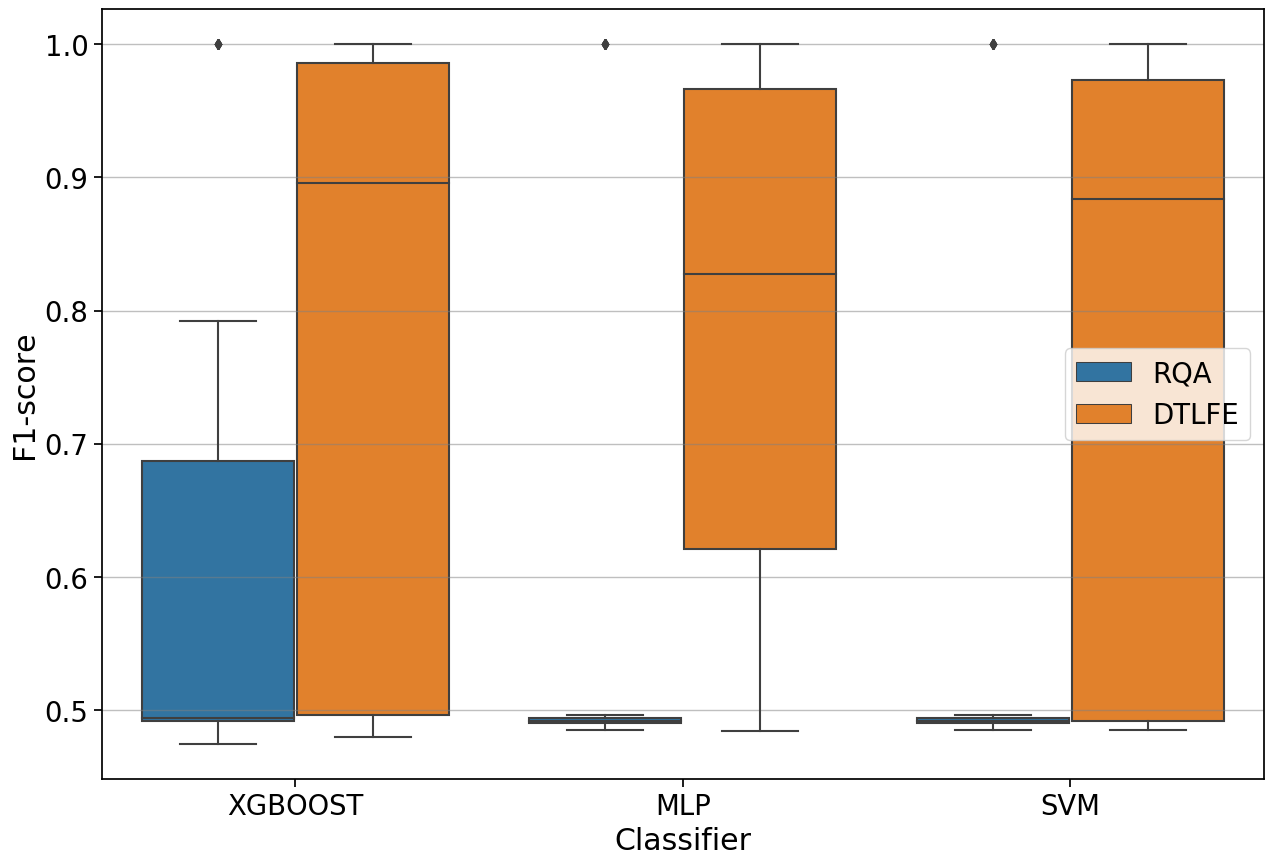

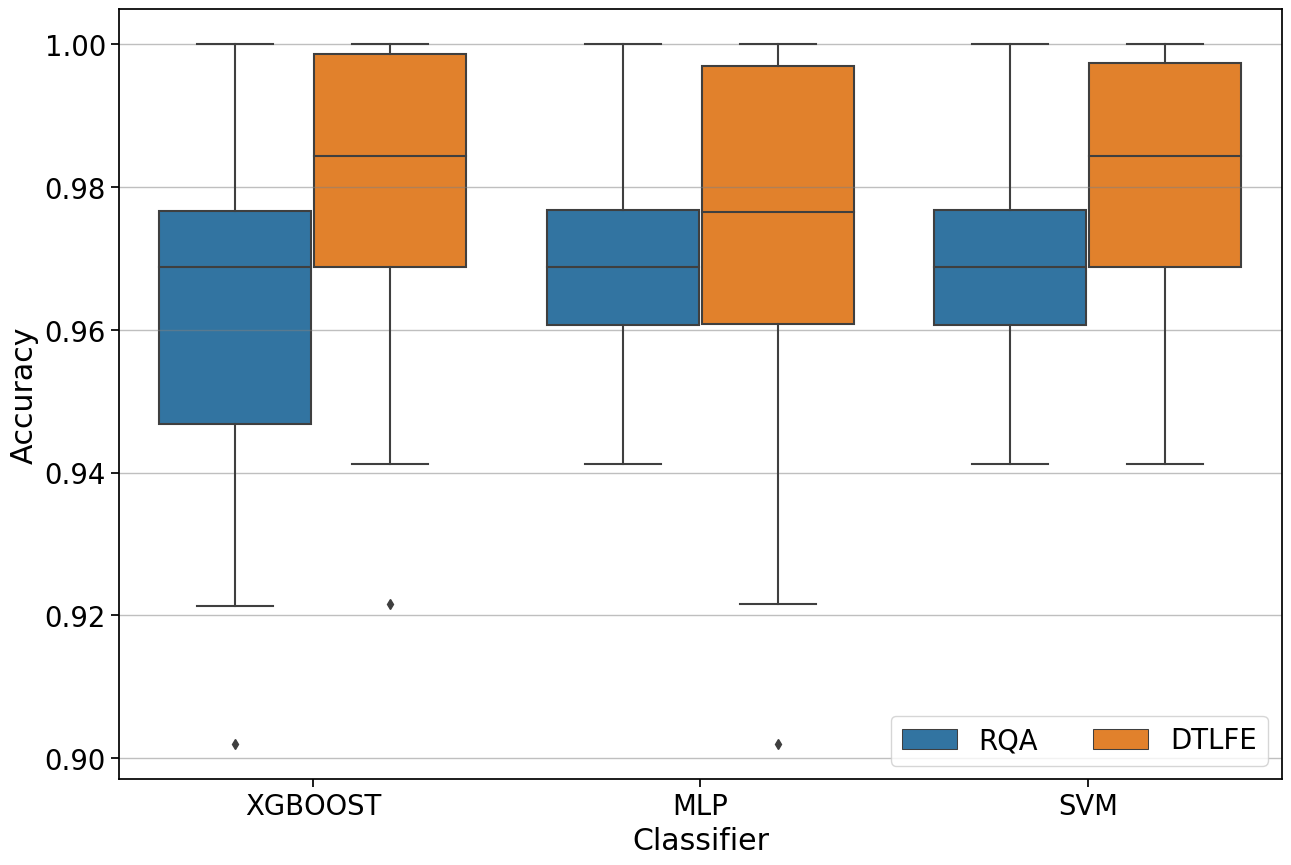

RQA vs. DLAFE (base de teste) - Comparativo de Classificadores


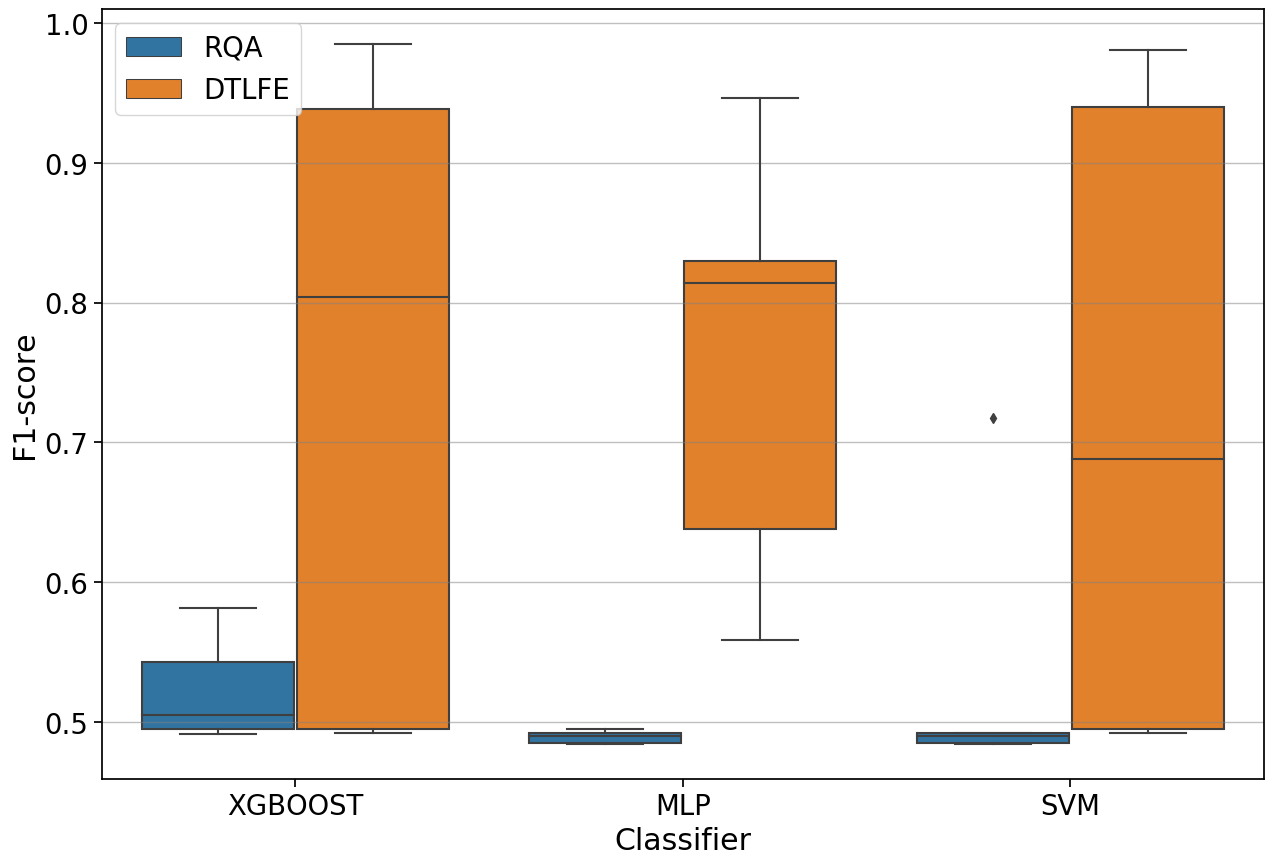

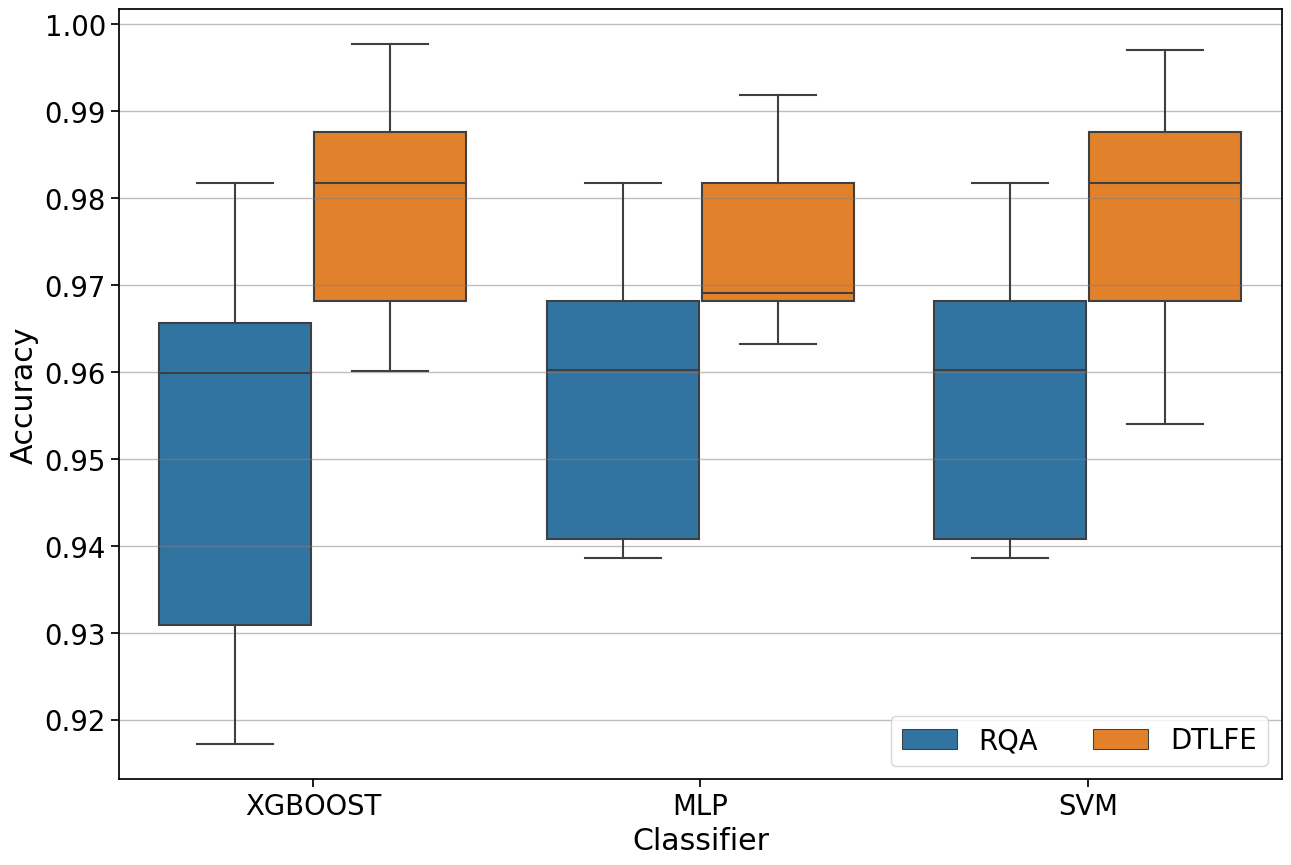

In [12]:
for b in ['treino','teste']:
    print(f"RQA vs. DLAFE (base de {b}) - Comparativo de Classificadores")
    
    df_ = df.query(f"base == '{b}'").reset_index()

    df_['feature'] = df_['method'].apply(lambda m: m.split('+')[0])
    df_['classifier'] = df_['method'].apply(lambda m: m.split('+')[1]) 
    
#     fig = plt.figure(figsize=(20,8));
#     df_.boxplot(by=['feature', 'classifier'], column=['f1', 'acc'], rot=90, figsize=(15,5));
#     plt.suptitle(f"RQA vs. DLAFE (base de {b})");
#     plt.show();
    
    fig, ax = plt.subplots(figsize=(15, 10))
    sns.boxplot(x="classifier", y="f1",
                hue="feature", order=["XGBOOST","MLP","SVM"],
                data=df_[df_['classifier']!='CNN'], 
                ax=ax, 
                # palette=sns_palette
               )
    ax.set(xlabel='Classifier', ylabel='F1-score')
    ax.legend(frameon=True, loc='best', ncol=1);    
    plt.show()
    fig.savefig(
        os.path.join(
            caminho_imagens_notebook,
            f'2_classificadores_{b}_f1.png', 
        ),
        format='png', 
        dpi=300,
        bbox_inches='tight', 
        pad_inches=0
    )
    
    fig, ax = plt.subplots(figsize=(15, 10))
    sns.boxplot(x="classifier", y="acc",
                hue="feature", order=["XGBOOST","MLP","SVM"],
                data=df_[df_['classifier']!='CNN'], 
                ax=ax, 
                # palette=sns_palette
               )
    ax.set(xlabel='Classifier', ylabel='Accuracy')
    ax.legend(frameon=True, loc='best', ncol=2);  
    # plt.suptitle(f"RQA vs. DLAFE (base de {b}) - Comparativo de Classificadores");
    plt.show();

    fig.savefig(
        os.path.join(
            caminho_imagens_notebook,
            f'2_classificadores_{b}_acuracia.png', 
        ),
        format='png', 
        dpi=300,
        bbox_inches='tight', 
        pad_inches=0
    )

    # fig.savefig(
    #     'D:/Users/diego/MEGA/Pesquisa/Papers/IEEE PES GM 2021/destination_path.jpg', 
    #     format='jpg',
    #     dpi=300,
    #     bbox_inches='tight', pad_inches=0

    # )

**CONCLUSÕES PARCIAIS:** 

...

### Desempenho por Aparelho

dish_washer - 9 (base de treino)


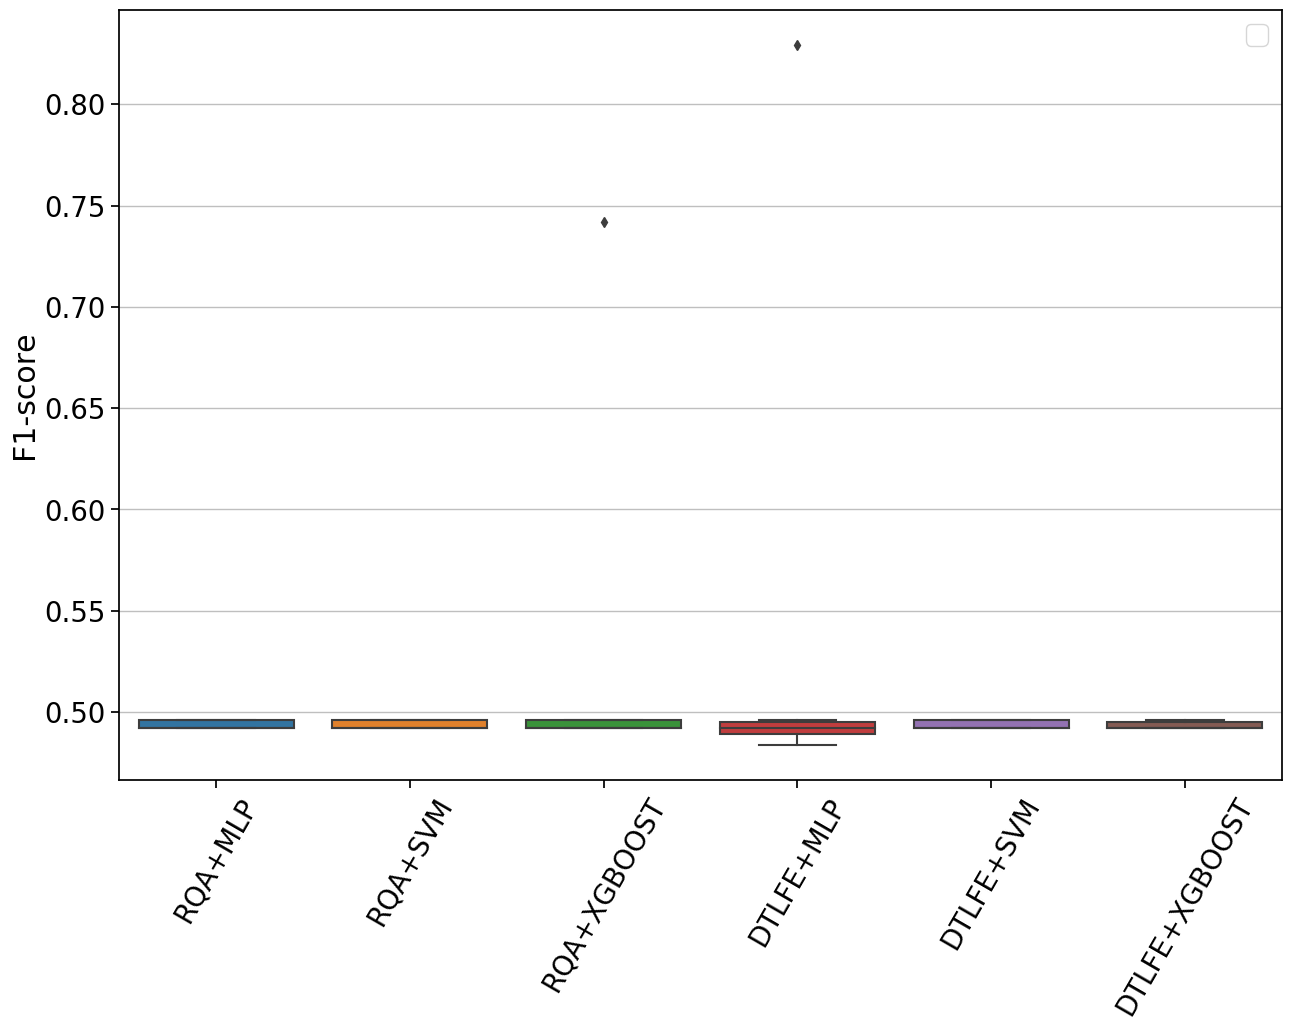

dish_washer - 9 (base de teste)


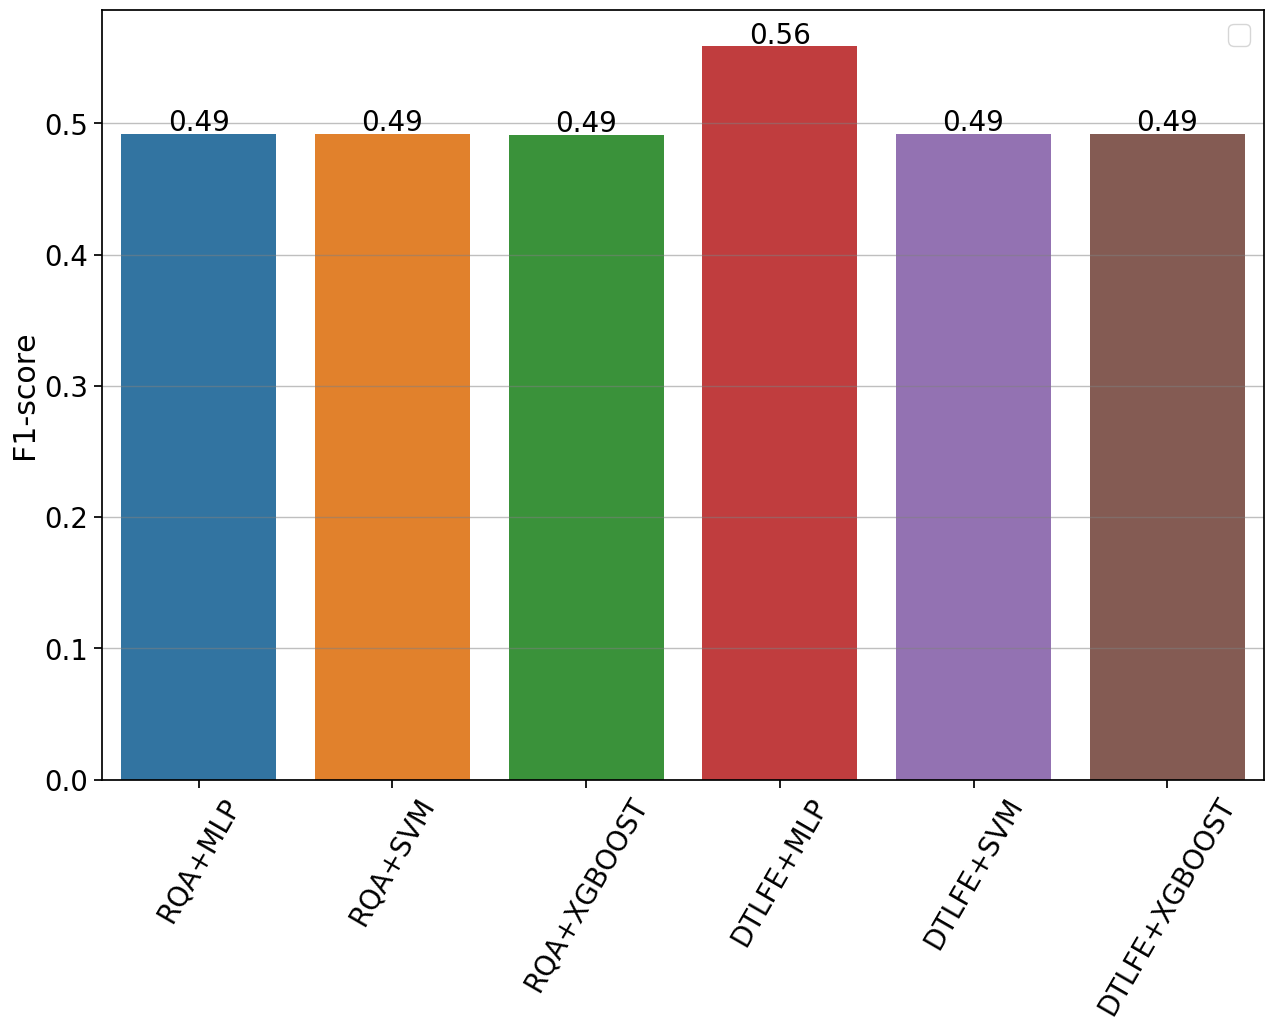

fridge - 7 (base de treino)


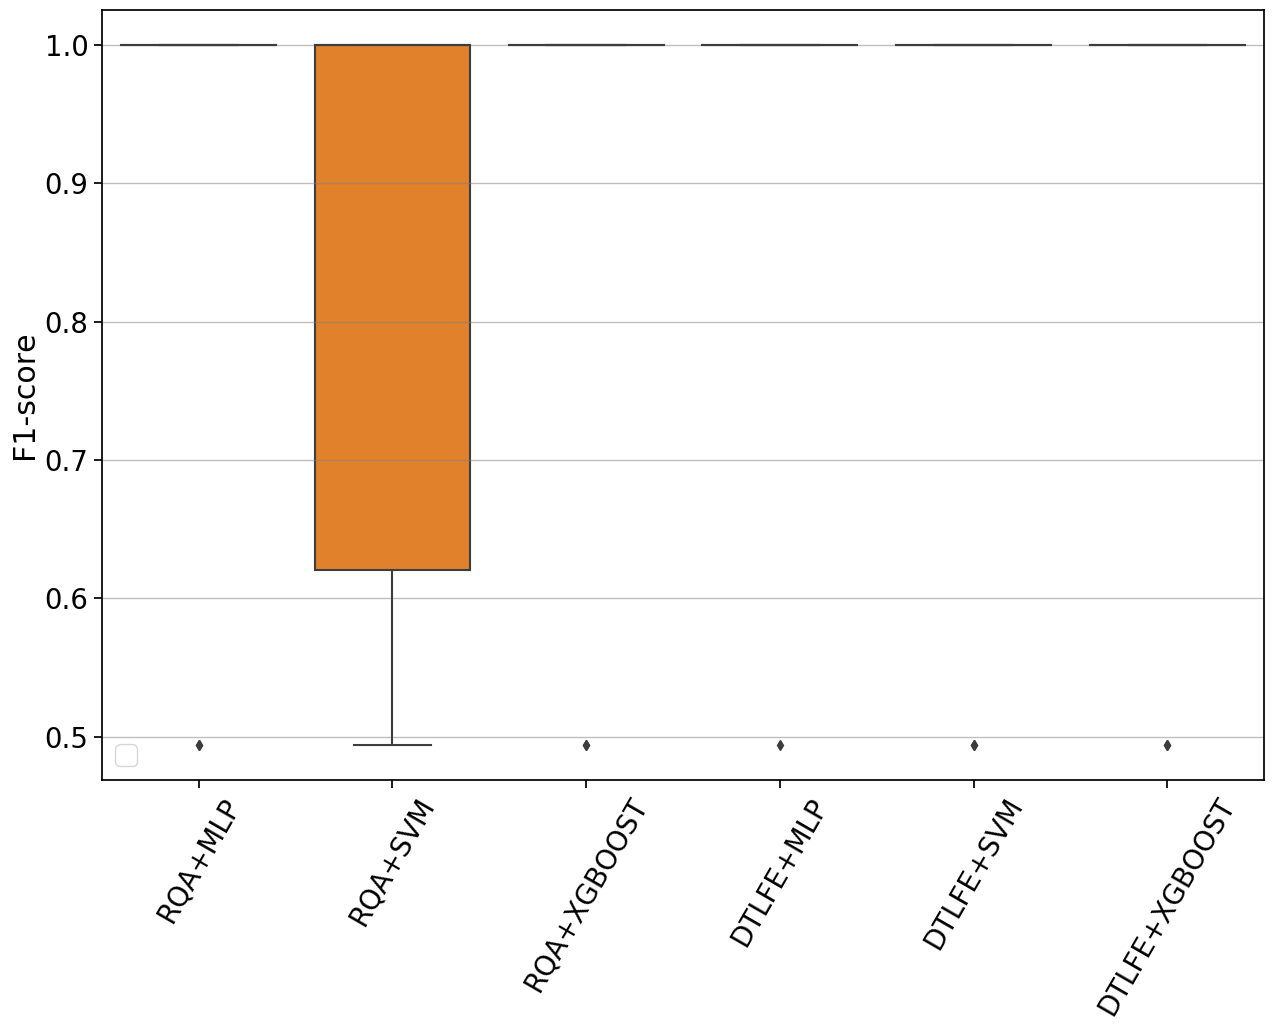

fridge - 7 (base de teste)


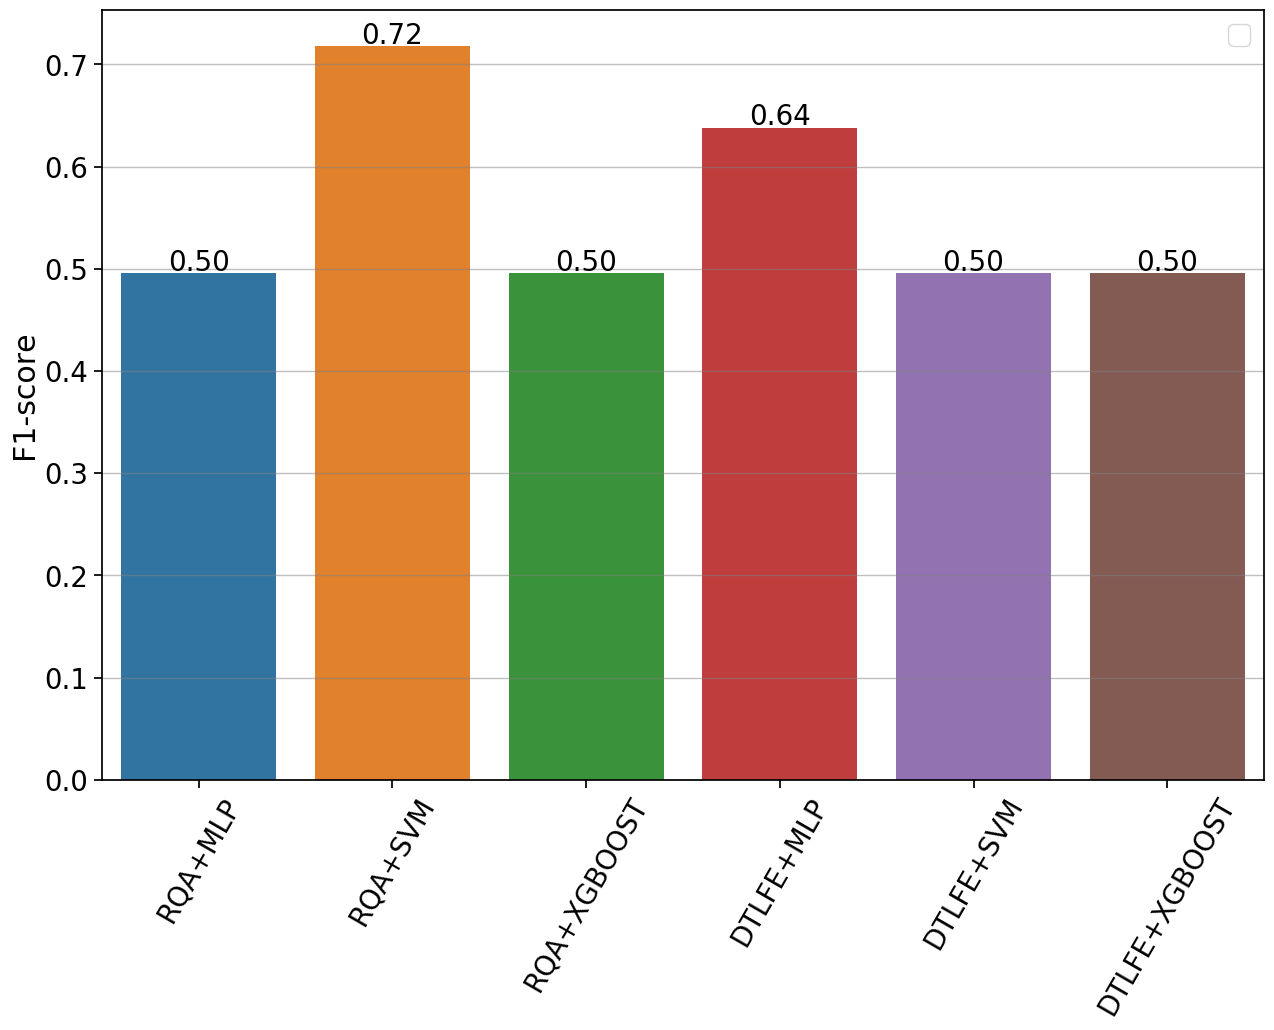

microwave - 16 (base de treino)


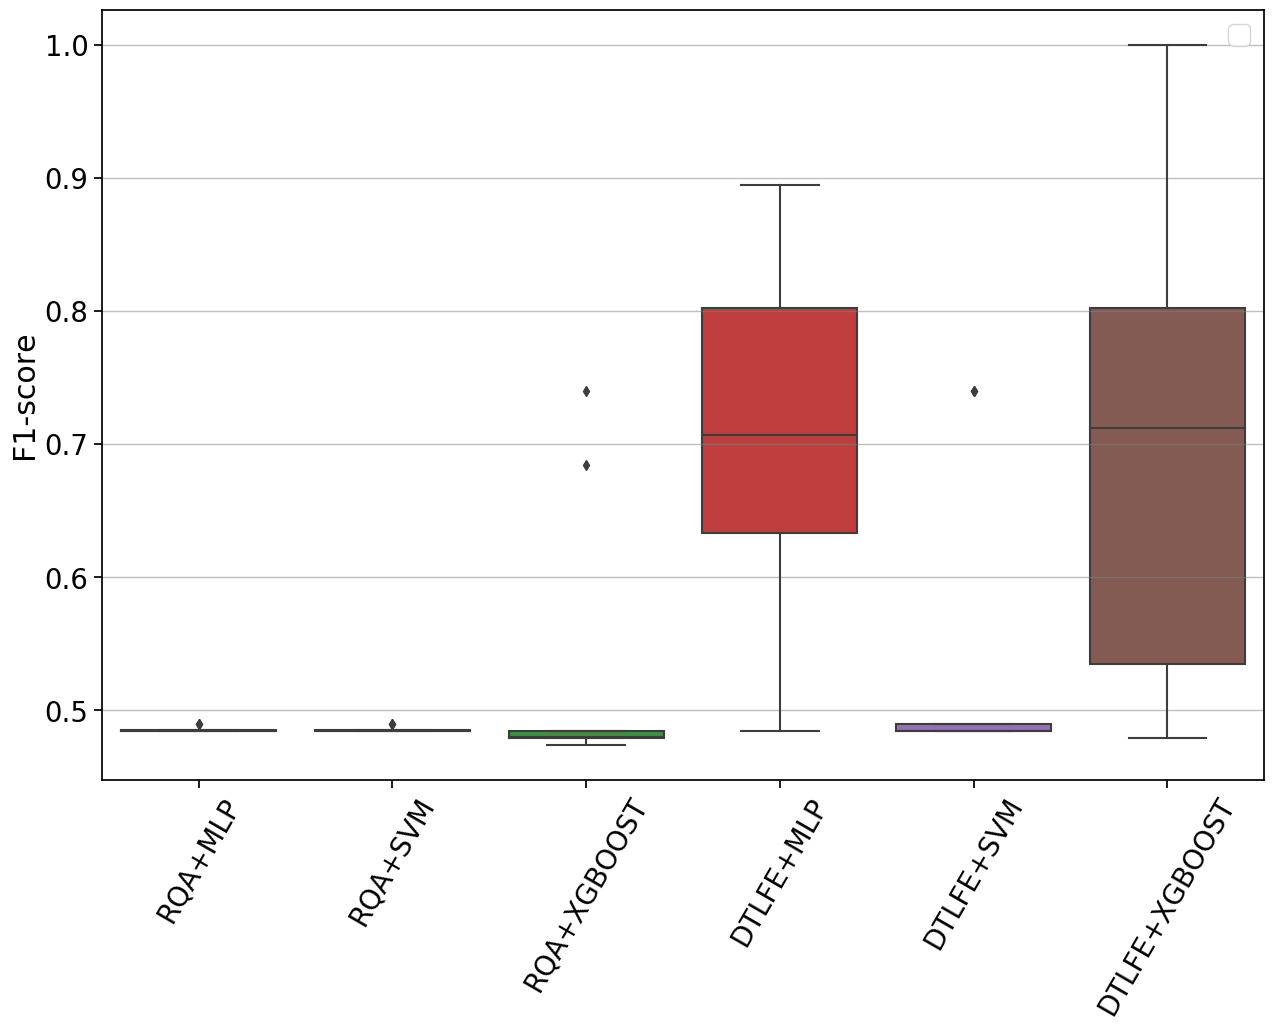

microwave - 16 (base de teste)


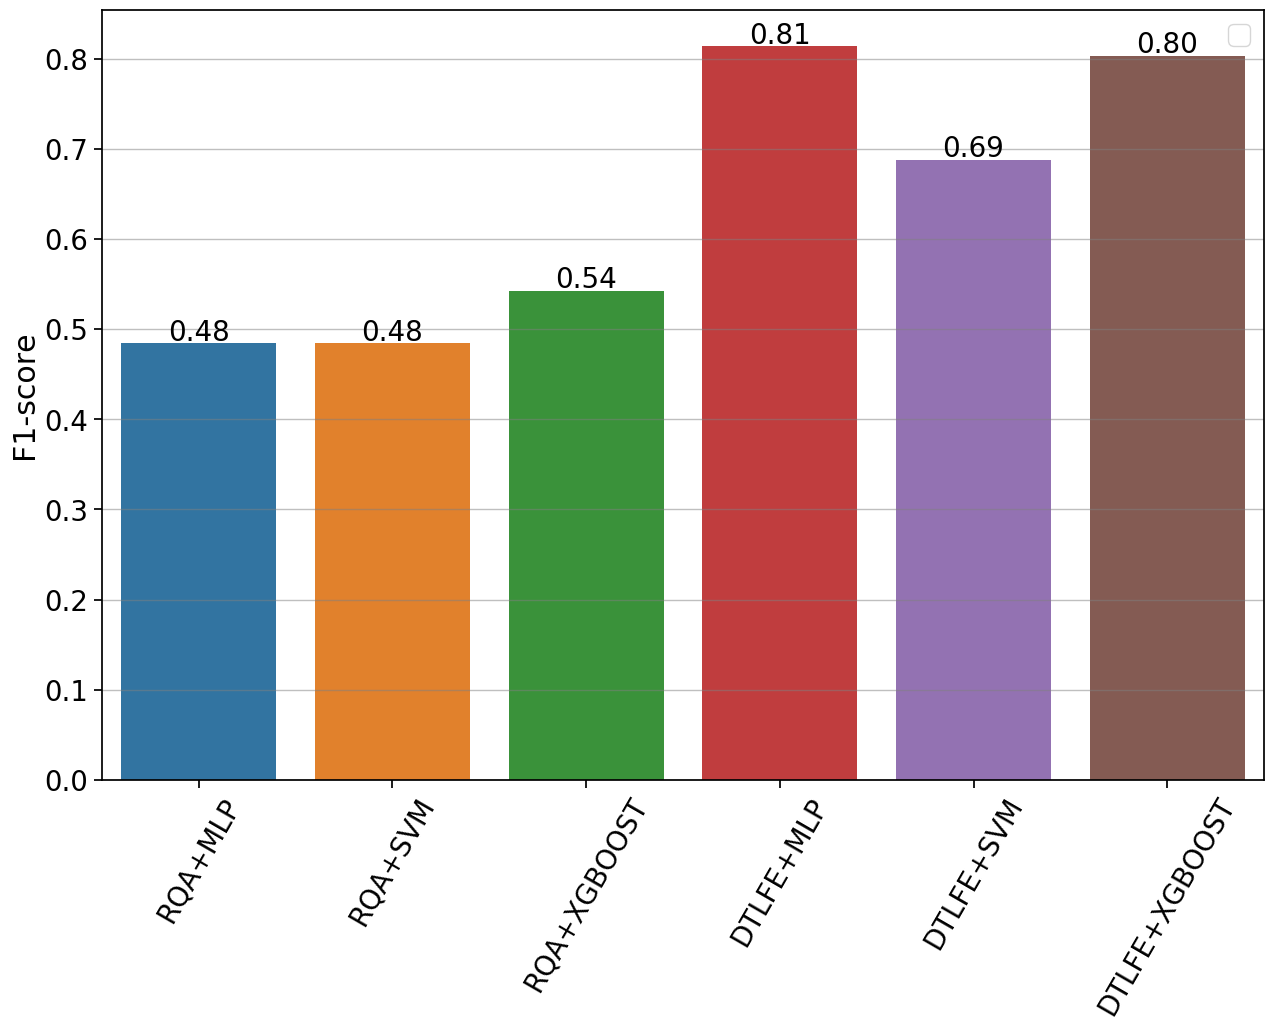

washer_dryer - 13 (base de treino)


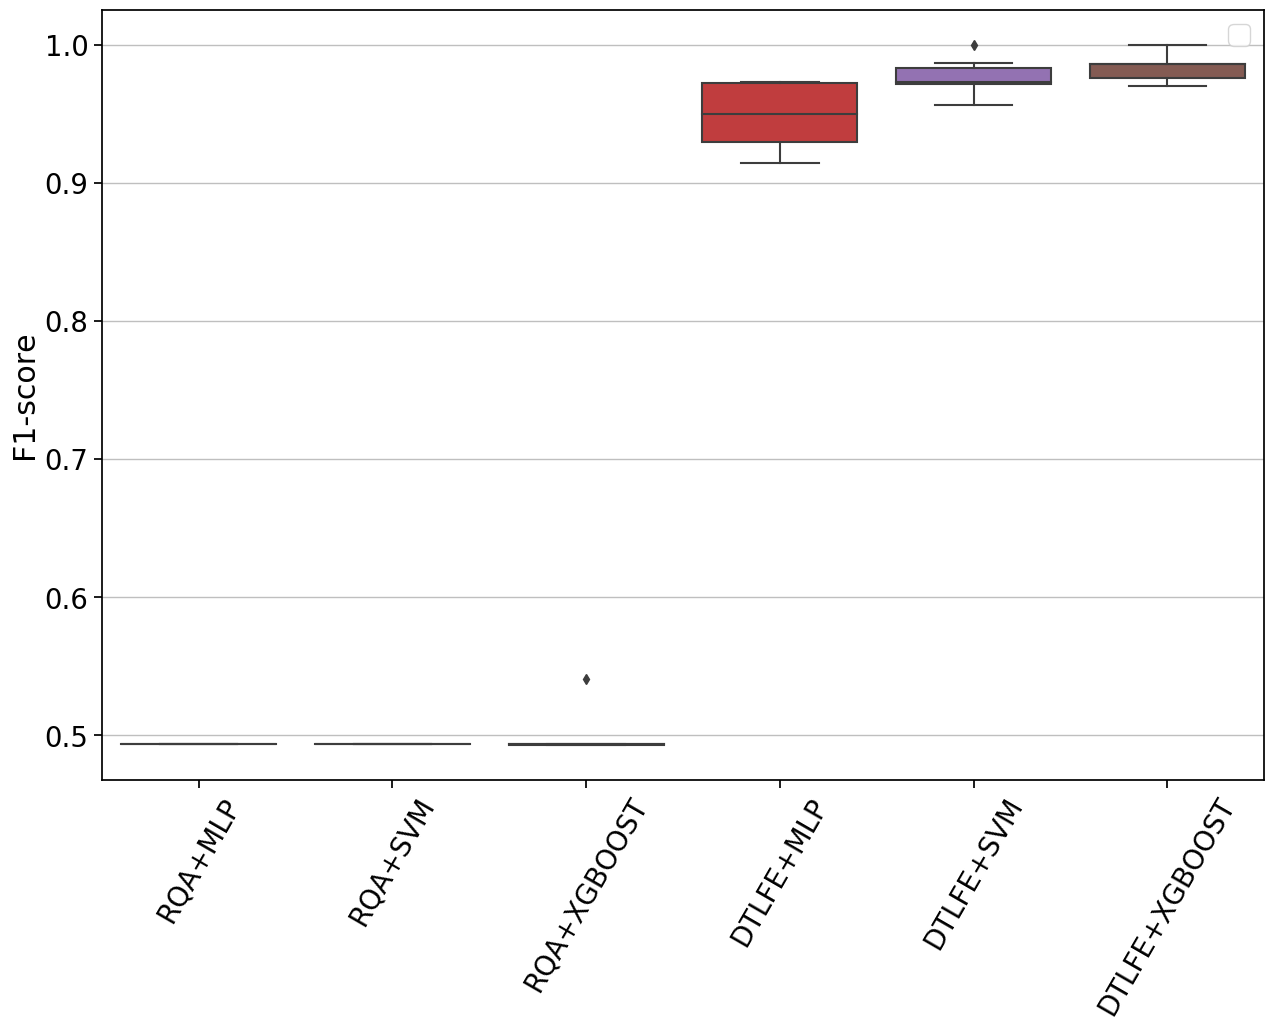

washer_dryer - 13 (base de teste)


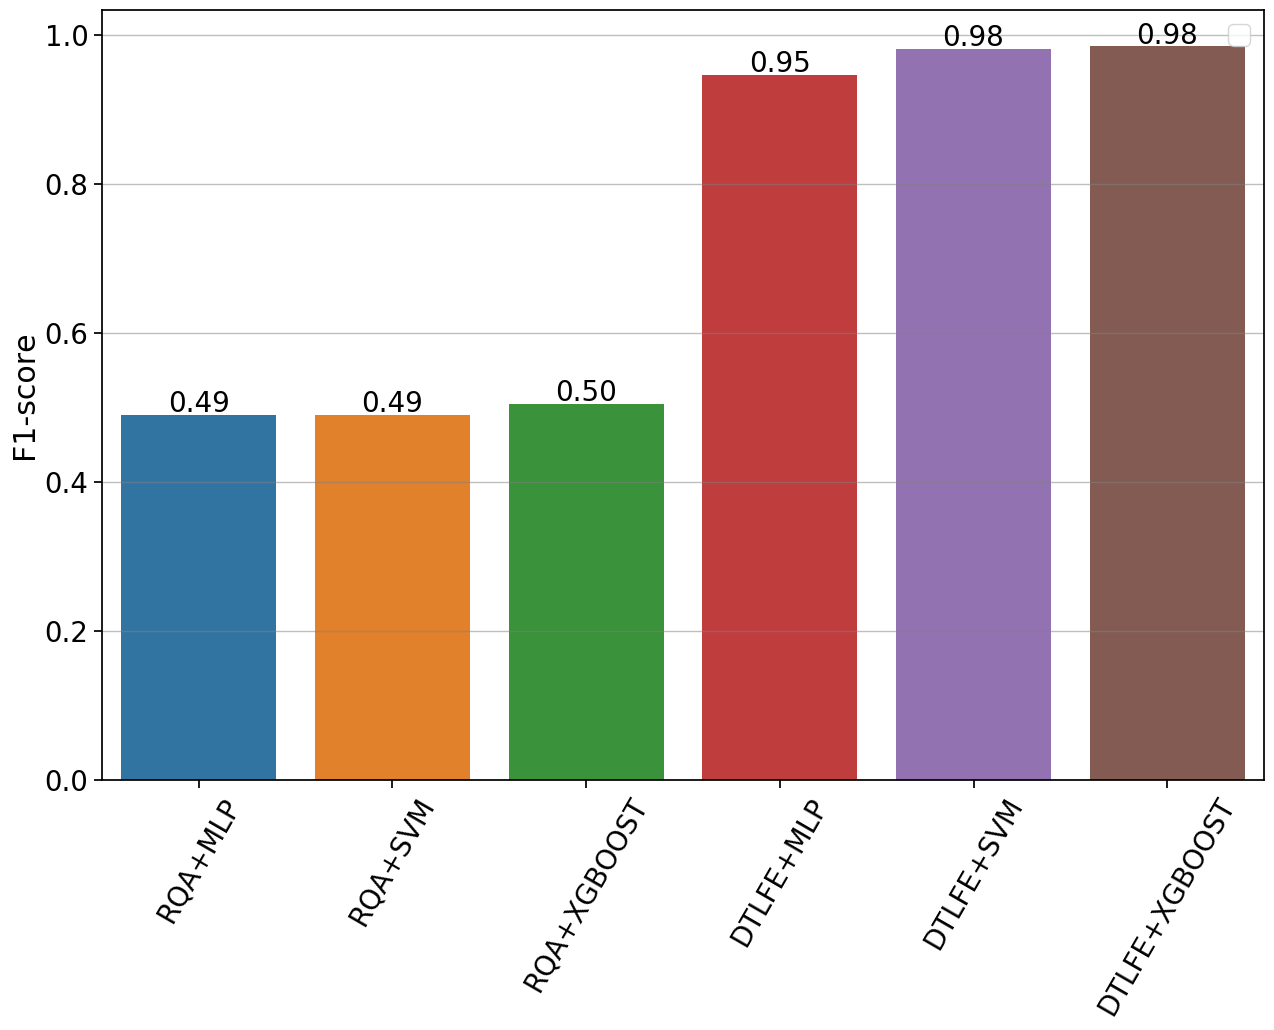

washer_dryer - 14 (base de treino)


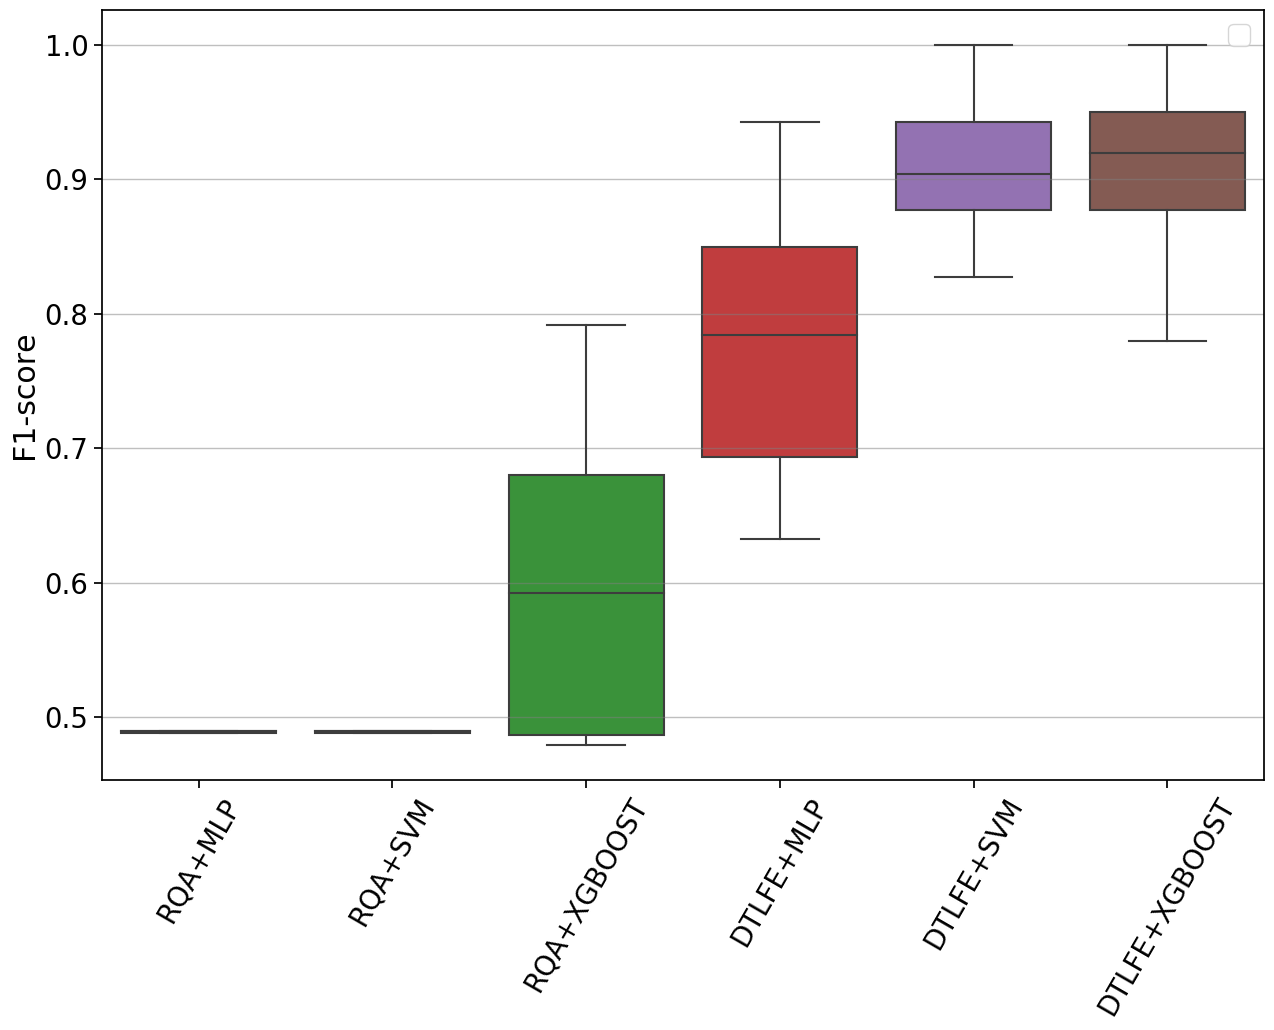

washer_dryer - 14 (base de teste)


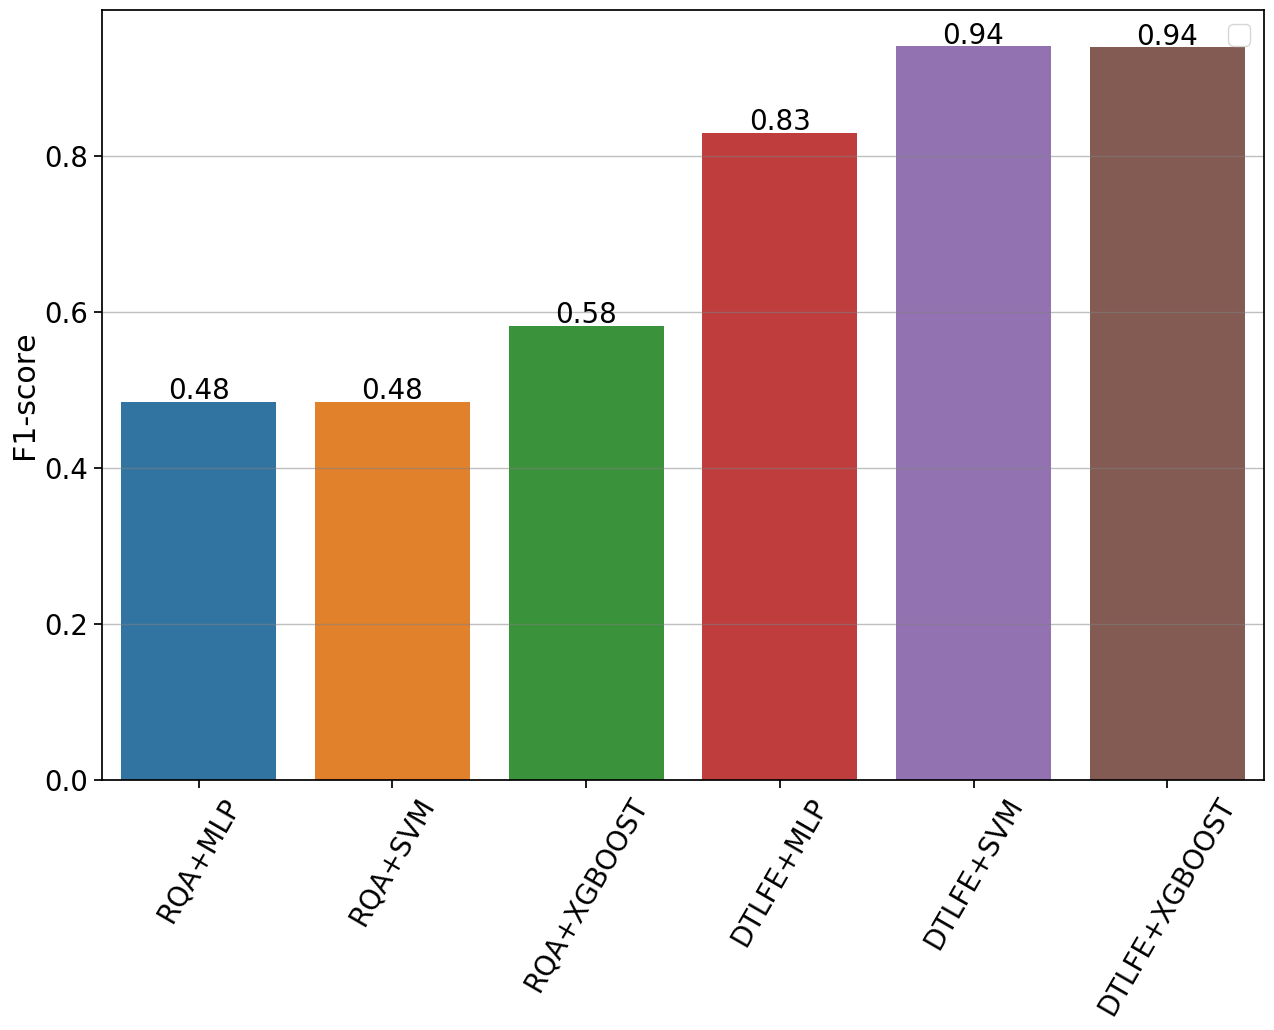

In [13]:
for a in df['appliance'].unique():
    
    #fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    
    for i, b in enumerate(['treino','teste']):

        df_ = df.query(f"appliance == '{a}' and base == '{b}'").reset_index()

        df_['feature'] = df_['method'].apply(lambda m: m.split('+')[0])
        df_['classifier'] = df_['method'].apply(lambda m: m.split('+')[1]) 

    #     fig = plt.figure(figsize=(20,8));
    #     df_.boxplot(by=['feature', 'classifier'], column=['f1', 'acc'], rot=90, figsize=(15,5));
    #     plt.suptitle(f"RQA vs. DLAFE (base de {b})");
    #     plt.show();
        
        print(f"{a} (base de {b})")
        fig, ax = plt.subplots(figsize=(15, 10))
        
        if b == 'treino':
            sns.boxplot(x="method", y="f1", #order=["XGBOOST","MLP","SVM"],
                        data=df_[df_['classifier']!='CNN'], 
                        ax=ax)
        else:
            g=sns.barplot(x="method", y="f1", #order=["XGBOOST","MLP","SVM"],
                        data=df_[df_['classifier']!='CNN'], 
                        ax=ax)
            # Inserting metrics over the bars
            for bar in g.patches:
                g.annotate(format(bar.get_height(), '.2f'), 
                (bar.get_x() + bar.get_width() / 2, 
                bar.get_height()), ha='center', va='center',
                size=20, xytext=(0, 8),
                textcoords='offset points')

        ax.set(xlabel='', ylabel='F1-score')#, title=f'F1-Score (base de {b})')
        ax.legend({});#frameon=False, loc='best', ncol=2); 

            #         sns.boxplot(x="appliance", y="acc",
#                     hue="method", #order=["XGBOOST","MLP","SVM"],
#                     data=df_[df_['classifier']!='CNN'], 
#                     ax=axes[1])
#         axes[1].set(xlabel='Appliance', ylabel='F1-score', title='Accuracy')
#         axes[1].legend(frameon=False, loc='best', ncol=2);  

        for tick in ax.get_xticklabels():
            tick.set_rotation(60);
        # plt.suptitle(f"{a} (base de {b})");
        plt.show()

        fig.savefig(
            os.path.join(
                caminho_imagens_notebook,
                f'3_aparelho_{a}_{b}_f1.png', 
            ),
            format='png', 
            dpi=300,
            bbox_inches='tight', 
            pad_inches=0
        )
        
#     plt.show();
    

## Análise do impacto de janelas

In [10]:
# melhor_metodologia
df = df_geral.query('base=="teste"').copy()

df.groupby('method').agg({'f1':['mean']}).sort_values([('f1','mean')],ascending=[False])

,f1
,mean
method,
DTLFE+XGBOOST,0.773
DTLFE+MLP,0.753
DTLFE+SVM,0.724
RP+CNN,0.648
RQA+XGBOOST,0.582
RQA+SVM,0.521
RQA+MLP,0.501


In [11]:
melhor_abordagem_geral = 'DTLFE+MLP'
df = df[df['method']==melhor_abordagem_geral]
df.groupby(['appliance','window_length']).agg({'acc': ['mean'], 'f1':['mean']}).sort_values(['appliance', ('f1','mean')],ascending=[True,False])


acc    f1
                                 mean  mean
appliance         window_length            
dish_washer - 9   2040          0.932 0.625
                  90            0.983 0.608
                  30            0.985 0.595
                  60            0.984 0.563
                  720           0.968 0.559
                  540           0.974 0.556
                  180           0.981 0.552
                  360           0.977 0.494
                  900           0.960 0.490
                  1080          0.960 0.490
fridge - 7        720           0.980 0.870
                  540           0.937 0.861
                  360           0.885 0.851
                  2040          0.993 0.832
                  180           0.790 0.788
                  900           0.982 0.781
                  90            0.753 0.752
                  60            0.737 0.735
                  30            0.694 0.686
                  1080          0.982 0.638
microwave - 16    900           0.963 0.814
                  1080          0.953 0.763
                  360           0.977 0.762
                  2040          0.898 0.744
                  180           0.983 0.726
                  60            0.990 0.717
                  540           0.963 0.713
                  720           0.953 0.700
                  30            0.991 0.683
                  90            0.987 0.669
washer_dryer - 13 90            0.993 0.955
                  60            0.990 0.933
                  30            0.990 0.918
                  2040          0.973 0.909
                  180           0.986 0.909
                  720           0.978 0.873
                  900           0.975 0.860
                  360           0.977 0.852
                  540           0.969 0.803
                  1080          0.960 0.800
washer_dryer - 14 2040          0.966 0.898
                  90            0.974 0.853
                  180           0.973 0.850
                  60            0.971 0.844
                  720           0.968 0.840
                  900           0.963 0.832
                  360           0.969 0.830
                  30            0.969 0.822
                  1080          0.945 0.758
                  540           0.954 0.710

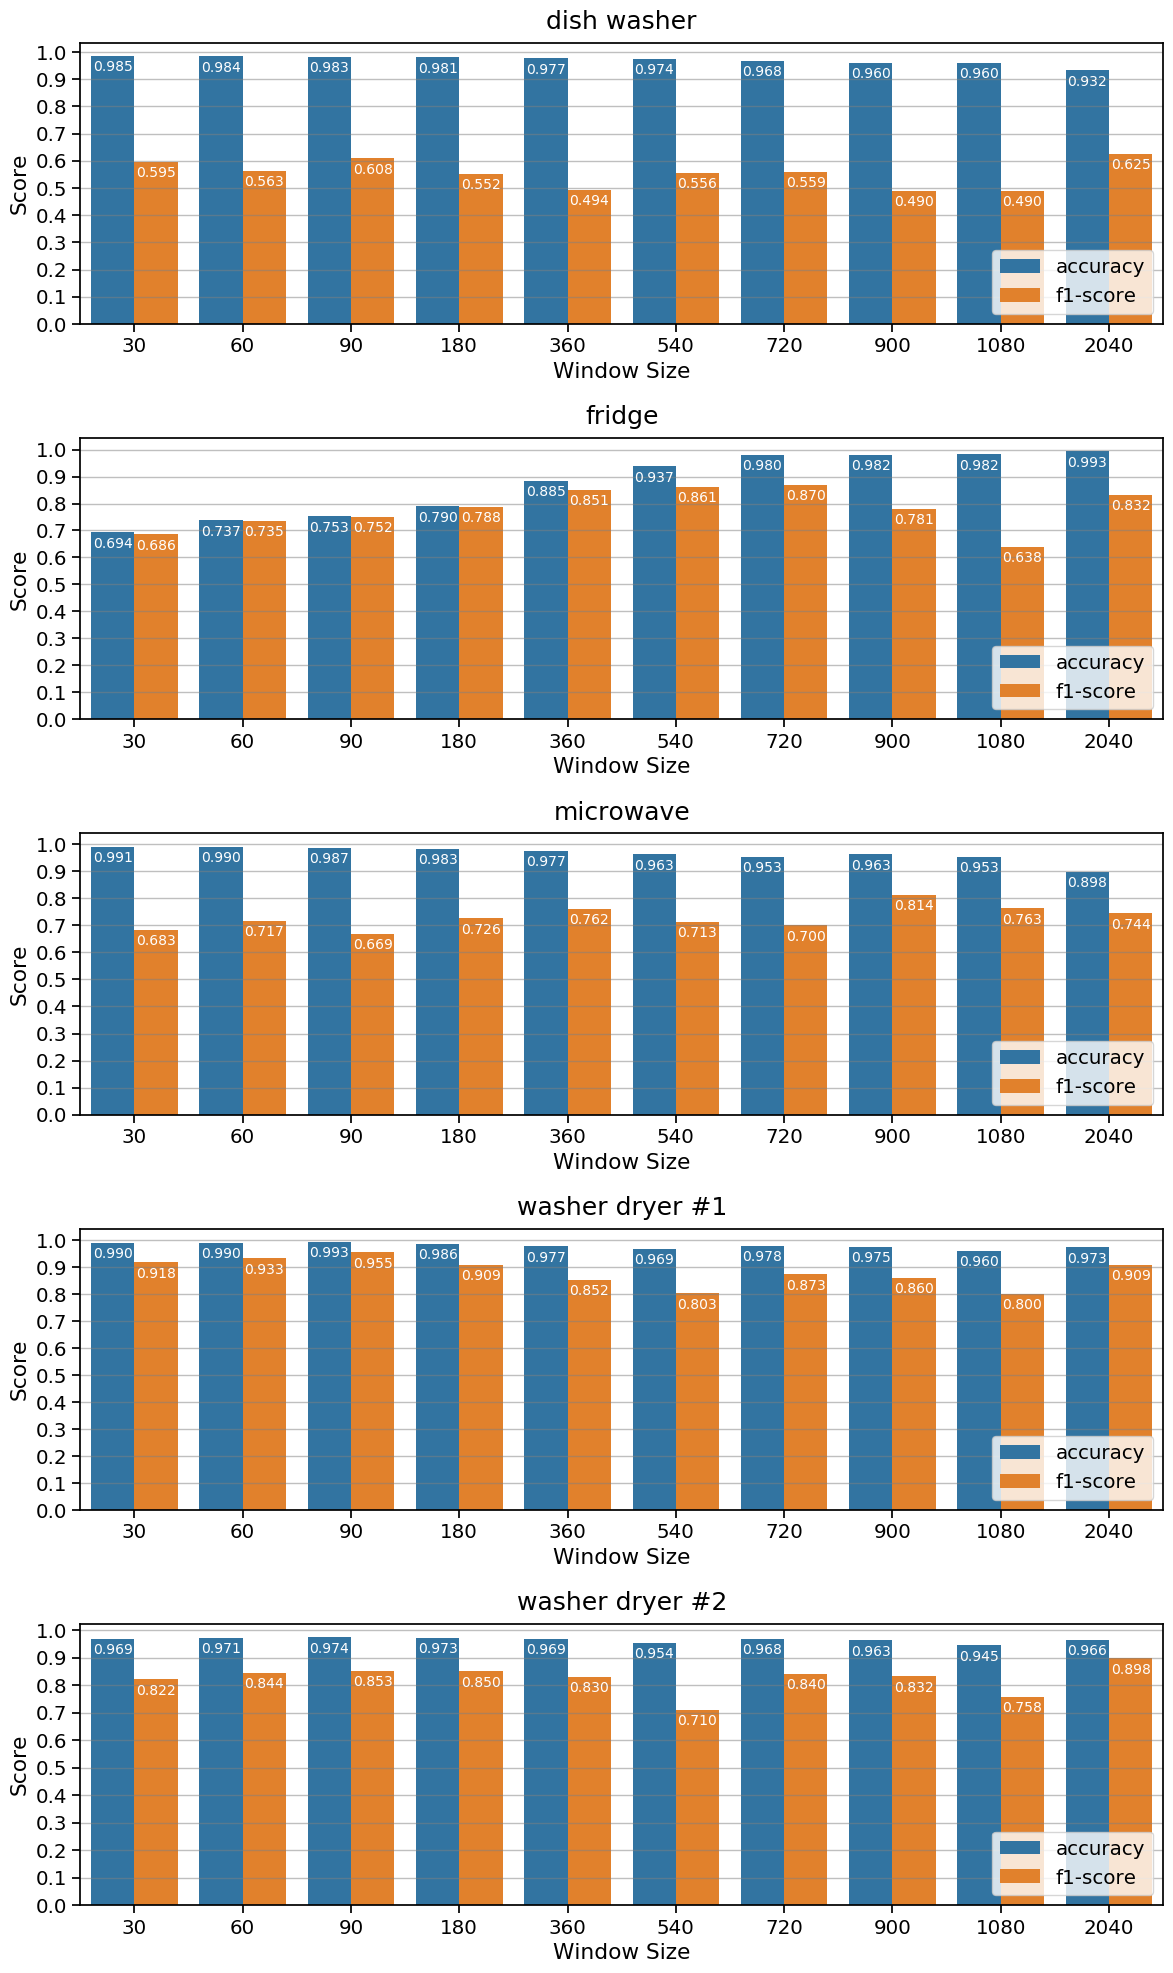

In [85]:
# libraries
import seaborn as sns

matplotlib.style.use('default')
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = 'gray'
matplotlib.rcParams['grid.linestyle'] = '-'
matplotlib.rcParams['grid.linewidth'] = 0.25
matplotlib.rcParams['grid.alpha'] = .5
sns.set(font_scale=1.3, style=None, palette=None)

# Graficos separados por aparelho
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.titlepad': 10
})
df_analise_janelas = df[['acc','f1']].stack().reset_index()
df_analise_janelas['level_1'] = df_analise_janelas['level_1'].apply(lambda x: 'accuracy' if x == 'acc' else 'f1-score')
df_analise_janelas['appliance'] = df_analise_janelas['level_0'].apply(
    lambda x: df[df.index==x]['appliance'].values[0])
df_analise_janelas['window_length'] = df_analise_janelas['level_0'].apply(
    lambda x: df[df.index==x]['window_length'].values[0])
df_analise_janelas = df_analise_janelas.rename(columns={
    'level_1': 'metric',
    0: 'value'
}).drop(columns=['level_0'])

fig, axs = plt.subplots(5,1, figsize=(12, 20))

# appliances = {
#     'dish_washer - 9': 'Lava-louças',
#     'fridge - 7': 'Refrigerador',
#     'microwave - 16': 'Micro-ondas',
#     'washer_dryer - 13': 'Máquina de lavar/secar roupas #1',
#     'washer_dryer - 14': 'Máquina de lavar/secar roupas #2'
# }
appliances = {
    'dish_washer - 9': 'dish washer',
    'fridge - 7': 'fridge',
    'microwave - 16': 'microwave',
    'washer_dryer - 13': 'washer dryer',
    'washer_dryer - 14': 'washer dryer'
}

for a, ax in zip(df['appliance'].unique(), axs):
    
    # Appliance label
    # appliance = a.split("-")[0].strip().replace("_"," ").lower()
    appliance = appliances[a]
    if all(k in a for k in ['washer', '13']):
        appliance += ' #1'
    elif all(k in a for k in ['washer', '14']):
        appliance += ' #2'
    
    df_ = df_analise_janelas.query(f"appliance == '{a}'").reset_index()
    
    g=sns.barplot(x="window_length", y="value", hue="metric", data=df_, ax=ax)
    # Remove legend title
    g.legend_.set_title(None) 
    # Inserting metrics over the bars
    for bar in g.patches:
        g.annotate(format(bar.get_height(), '.3f'), 
        (bar.get_x() + bar.get_width() / 2, 
        bar.get_height()), ha='center', va='center',
        size=10, 
        xytext=(0, -8),
        textcoords='offset points', 
        color='white',)
    ax.set(
        title=appliance, 
        ylabel='Score', xlabel='Window Size',     
        # #xticklabels=df_avg['feature'],
        yticks=np.arange(0, np.max(df_['value'])+.1, .1)  
    );
    ax.legend(loc='lower right');
plt.tight_layout();
plt.show();
fig.savefig(
    os.path.join(
        caminho_imagens_notebook,
        f'4_janelas.png', 
    ),
    format='png', 
    dpi=300,
    bbox_inches='tight', 
    pad_inches=0
)

In [57]:
# ...

...

In [14]:
%load_ext watermark

In [15]:
%watermark -a "Diego Luiz Cavalca" -u -n -t -z -v -m -g

Author: Diego Luiz Cavalca

Last updated: Thu Jun 10 2021 21:33:49Hora oficial do Brasil

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.21.0

Compiler    : MSC v.1928 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit

Git hash: 5e5bccaaf9e541e11be67706c7eb7d7b39a8be65

